In [ ]:
import datetime as dt
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cartopy.feature
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import xarray as xr
import math
import netCDF4
#from get_ellipse_metrics import get_emetrics_max_min
from fitEllipse2_new import fitEllipseContour
from geopy.distance import great_circle
from matplotlib.patches import Polygon
from matplotlib import cm #colormaps!
import copy
import os
import scipy.stats
import pickle
import pandas as pd
import matplotlib.ticker as mticker

In [ ]:
## now with these it should be easy enough to make figures for each of the variables
infile = open("ephi_wind10_1.p", 'rb') 
e10 = pickle.load(infile)
infile.close()

infile = open("ephi_ratio10_1.p", 'rb')
ephi_ratio10 = pickle.load(infile)
infile.close()

infile = open("ephi_cenlat10_1.p", 'rb')
ephi_cenlat10 = pickle.load(infile)
infile.close()

infile = open("ephi_size10_1.p", 'rb')
ephi_size10 = pickle.load(infile)
infile.close()

infile = open("ephi10_1.p", 'rb')
ephi10 = pickle.load(infile)
infile.close()

##Open temp related pickles
infile = open("save_time.p",'rb')
year_ref = pickle.load(infile)
infile.close()

infile = open("save.p",'rb')
temp_ref = pickle.load(infile)
infile.close()

infile = open("lats.p",'rb')
lats = pickle.load(infile)
infile.close()

infile = open("lons.p",'rb')
lons = pickle.load(infile)
infile.close()

In [ ]:
##need to do something to code in dates for x-axis 
year = [2010,2012,2013,2018]
sswcl = [11,13,14,19]

normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()
leap_year = pd.date_range('1999-12-01','2000-04-01', 
              freq='6H').strftime("%m/%d").tolist()

dates = [(0,485),(88,269),(0,485),(72,253)]
print(dates[0])

e10[0,int(dates[0][0]):int(dates[0][1])]
xt = leap_year[int(dates[0][0]):int(dates[0][1])]

(0, 485)


In [ ]:
## averaging temp values in grid
tempval = np.empty((20,488,64,134))
tempval[:] = np.nan

yearnot = 0

for i in np.arange(1999,2019): 
    #print(i)
    #print(yearnot)
    year_save = temp_ref[np.where(year_ref==i)]
    #print(year_save.shape)
    if i == 1999 or i == 2003 or i == 2007 or i == 2011 or i ==2015: #account for leap years in entering data
        tempval[yearnot,:,:,:] = year_save
        yearnot = yearnot+1
    else:
        tempval[yearnot,0:360,:,:] = year_save[0:360,:,:]
        tempval[yearnot,364:,:,:] = year_save[360:,:,:]
        yearnot = yearnot+1

tempvals = tempval[:,:,23:39,81:117]
print(tempvals.shape)

(20, 488, 16, 36)


In [ ]:
#Average temperature
#first along lons
temps1 = np.nanmean(tempvals,axis=3)
temps = np.nanmean(temps1,axis=2)

print(temps.shape)
tem = temps-273.15 #convert to C

print(tem)

(20, 488)
[[ 3.80354886  5.49172024  6.14330614 ...  2.23642375  1.67289293
   1.9326789 ]
 [-3.61277873 -5.05296088 -6.25801188 ...  0.01446262 -1.43375244
  -2.33519762]
 [ 2.40796136  1.78934631  1.3419654  ...  0.10287543 -1.5608785
  -1.43728231]
 ...
 [-2.28072713 -3.05290663 -3.37446696 ...  3.7121894   2.68659871
   2.17429335]
 [ 1.83451402  2.43709886  3.42402547 ...  0.94628974 -0.98207533
  -2.92102322]
 [ 4.43947076  4.08087904  3.65387031 ... -6.57866347 -7.70593872
  -7.41809692]]


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [ ]:
#Climo time
rat10 = np.nanmean(ephi_ratio10,axis=0)
wind10 = np.nanmean(e10,axis=0)
cenl10 = np.nanmean(ephi_cenlat10,axis=0)
size10 = np.nanmean(ephi_size10,axis=0)
ep10 = np.nanmean(ephi10,axis=0)
tem10 = np.nanmean(tem,axis=0)

l = leap_year[0:-1]

rat10_sd = np.nanstd(ephi_ratio10,axis=0)
wind10_sd = np.nanstd(e10,axis=0)
cenl10_sd = np.nanstd(ephi_cenlat10,axis=0)
size10_sd = np.nanstd(ephi_size10,axis=0)
ep10_sd = np.nanstd(ephi10,axis=0)
tem10_sd = np.nanstd(tem,axis=0)

pos_rat = rat10 + rat10_sd
pos_wind = wind10 + wind10_sd
pos_cenl = cenl10 + cenl10_sd
pos_size = size10 + size10_sd
pos_ep = ep10 + ep10_sd
pos_t = tem10 + tem10_sd


neg_rat = rat10 - rat10_sd
neg_wind = wind10 - wind10_sd
neg_cenl = cenl10 - cenl10_sd
neg_size = size10 - size10_sd
neg_ep = ep10 - ep10_sd
neg_t = tem10 - tem10_sd

In [ ]:
##SSW Averaging Timelines
ssw_wind = np.empty((11,181))
ssw_wind[:] = np.nan

ssw_rat = np.empty((11,181))
ssw_rat[:] = np.nan

ssw_size = np.empty((11,181))
ssw_size[:] = np.nan

ssw_cenl = np.empty((11,181))
ssw_cenl[:] = np.nan

ssw_ep= np.empty((11,181))
ssw_ep[:] = np.nan

ssw_t= np.empty((11,181))
ssw_t[:] = np.nan


year2 = [2001,2002,2003,2005,2006,2007,2008,2009,2012,2017,2018]
sswcl2 = [2,3,4,6,7,8,9,10,13,18,19]
dates2 = [(56,237),(136,317),(88,269),(148,329),(284,465),(276,457),(160,341),(224,405),(92,273),(236,417),(72,253)]

for i in range(len(year2)):
    d1 = int(dates2[i][0])
    d2 = int(dates2[i][1])
    
    ##diagnostics
    
    w = e10[sswcl2[i],d1:d2] #wind
    ssw_wind[i] = w[:]
    
    rat = ephi_ratio10[sswcl2[i],d1:d2]
    ssw_rat[i] = rat[:]
    
    cl = ephi_cenlat10[sswcl2[i],d1:d2]
    ssw_cenl[i] = cl[:]
    
    sz = ephi_size10[sswcl2[i],d1:d2]
    ssw_size[i] = sz[:]
    
    ep = ephi10[sswcl2[i],d1:d2]
    ssw_ep[i] = ep[:]
    
    tm = tem[sswcl2[i],d1:d2]
    ssw_t[i] = tm[:]

sswrat10 = np.nanmean(ssw_rat,axis=0)
sswwind10 = np.nanmean(ssw_wind,axis=0)
sswcenl10 = np.nanmean(ssw_cenl,axis=0)
sswsize10 = np.nanmean(ssw_size,axis=0)
sswep10 = np.nanmean(ssw_ep,axis=0)
sswt10 = np.nanmean(ssw_t,axis=0)

sswrat10_sd = np.nanstd(ssw_rat,axis=0)
sswwind10_sd = np.nanstd(ssw_wind,axis=0)
sswcenl10_sd = np.nanstd(ssw_cenl,axis=0)
sswsize10_sd = np.nanstd(ssw_size,axis=0)
sswep10_sd = np.nanstd(ssw_ep,axis=0)
sswt10_sd = np.nanstd(ssw_t,axis=0)

pos_sswrat = sswrat10 + sswrat10_sd
pos_sswwind = sswwind10 + sswwind10_sd
pos_sswcenl = sswcenl10 + sswcenl10_sd
pos_sswsize = sswsize10 + sswsize10_sd
pos_sswep = sswep10 + sswep10_sd
pos_sswt= sswt10 + sswt10_sd

neg_sswrat = sswrat10 - sswrat10_sd
neg_sswwind = sswwind10 - sswwind10_sd
neg_sswcenl = sswcenl10 - sswcenl10_sd
neg_sswsize = sswsize10 - sswsize10_sd
neg_sswep = sswep10 - sswep10_sd
neg_sswt = sswt10 - sswt10_sd

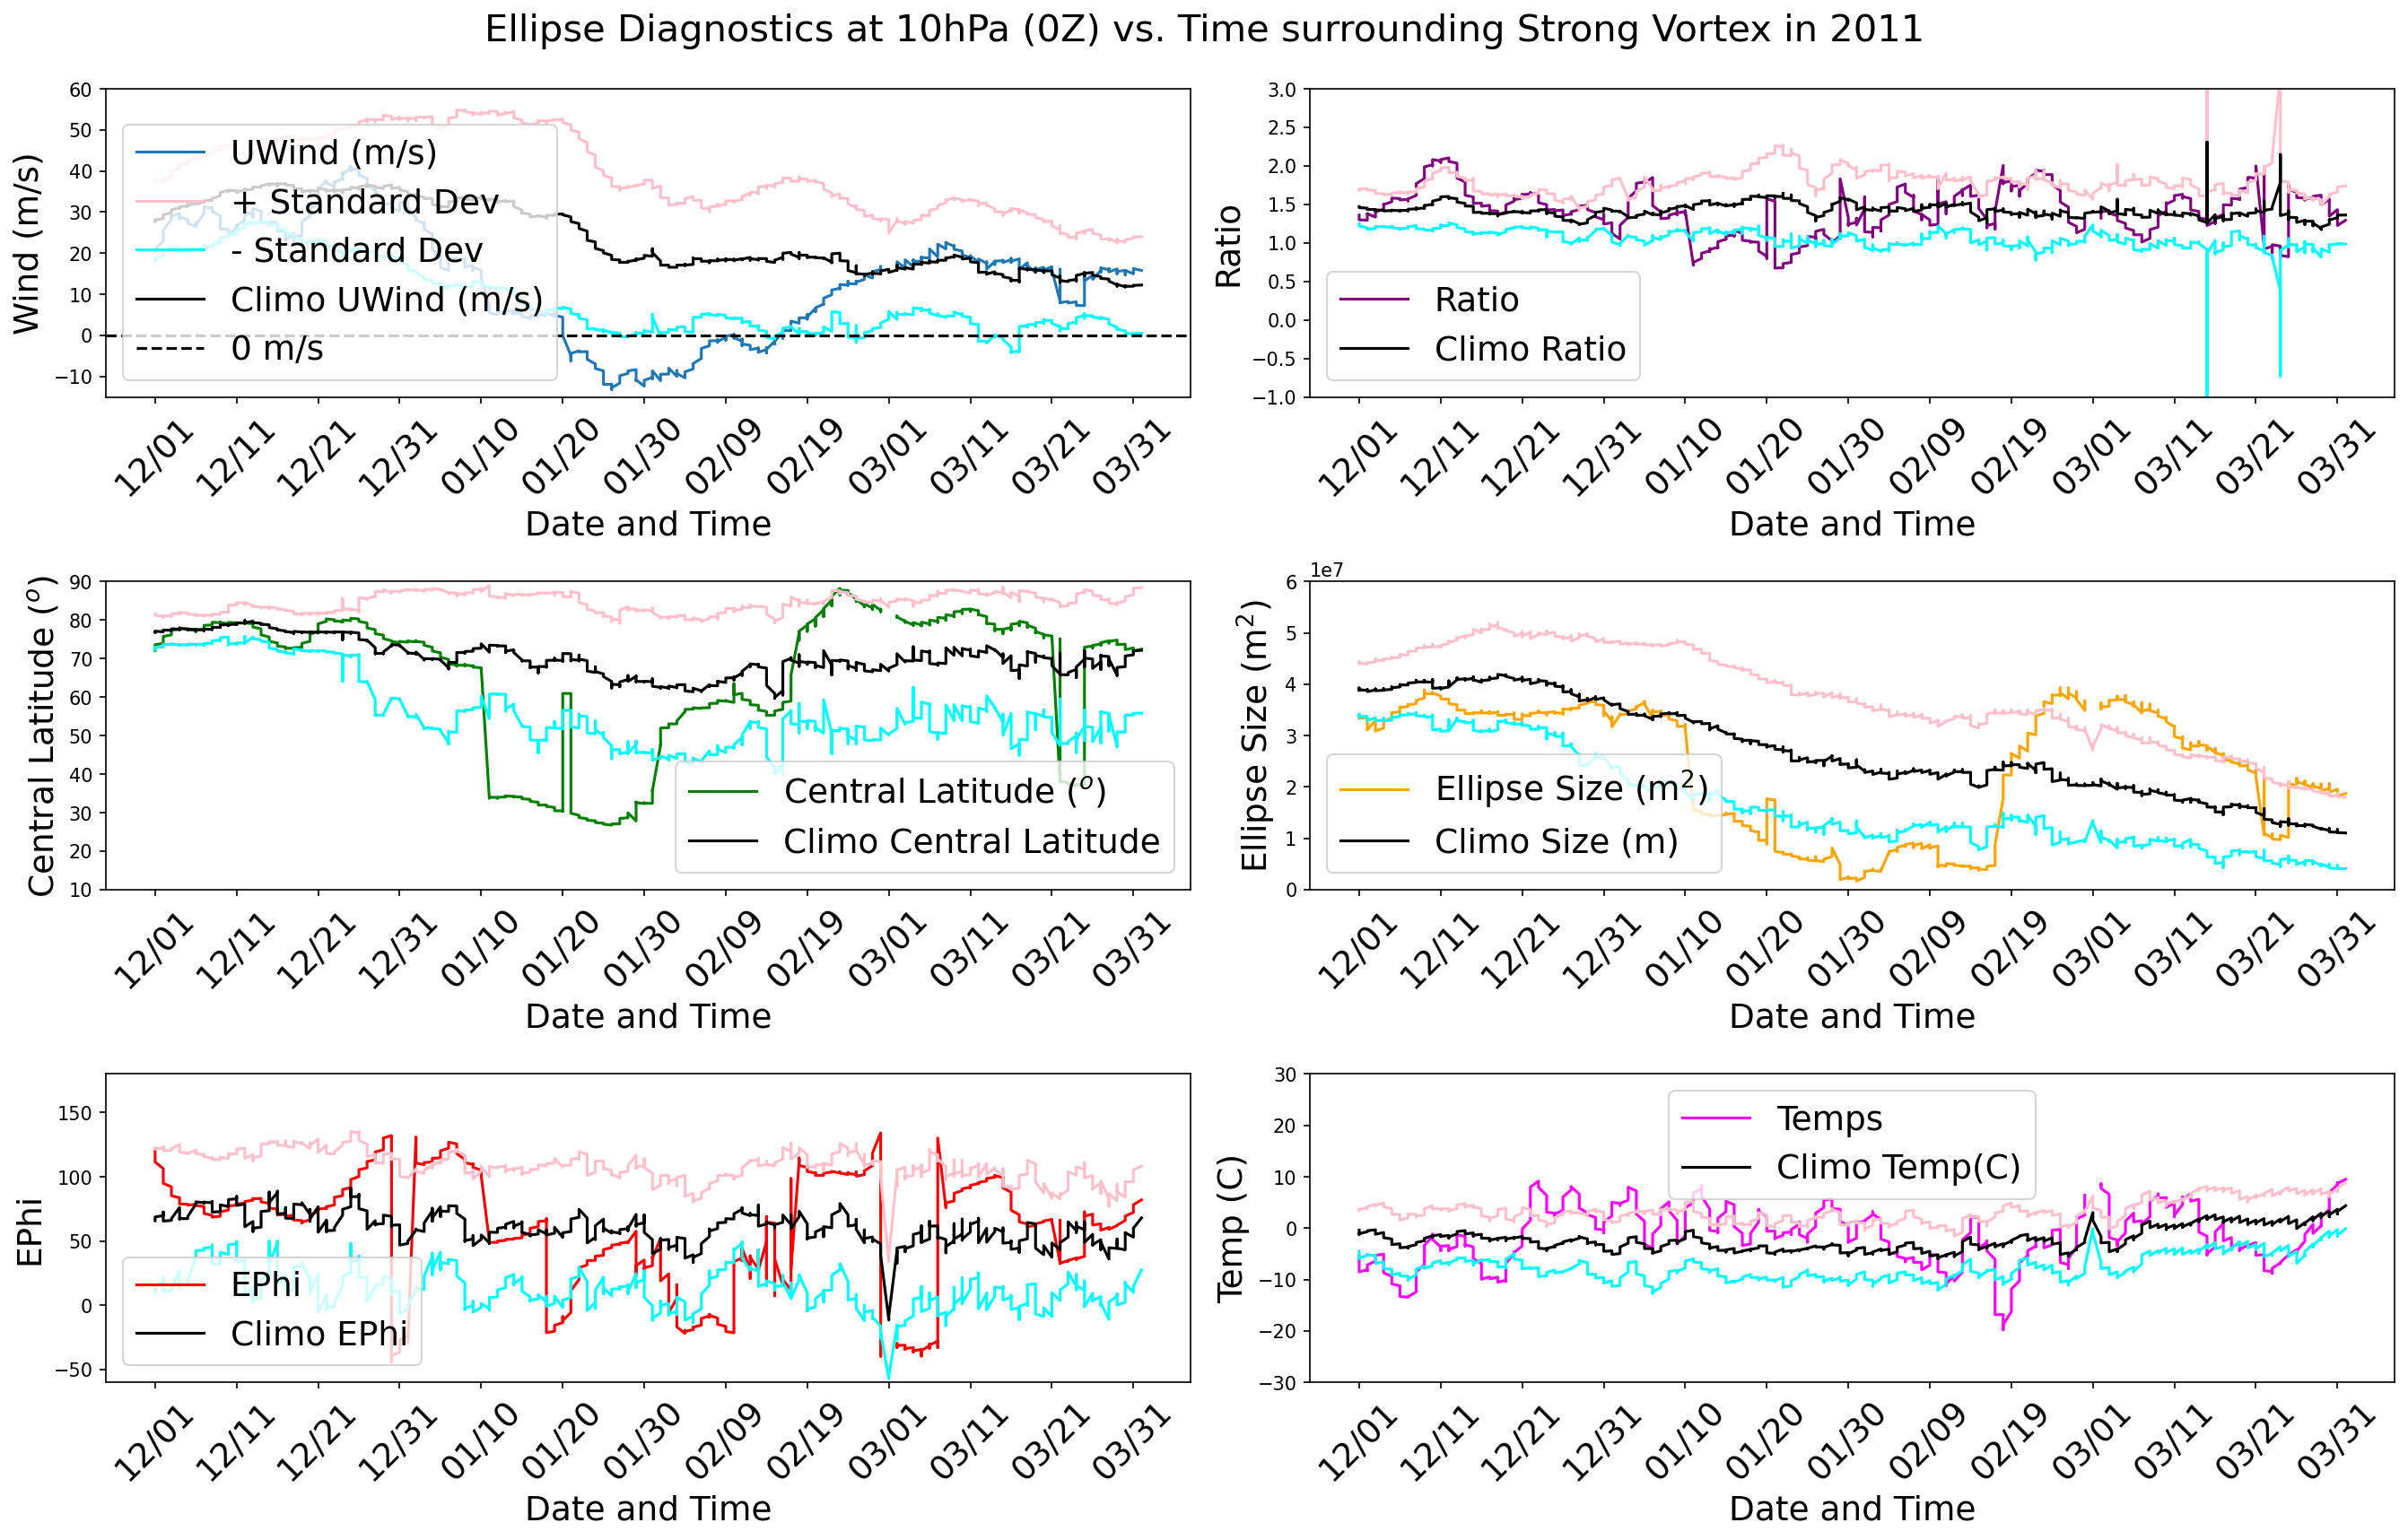

In [ ]:
##specific year:2011
myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()

y = str(year[0])
    
##diagnostics
    
w = e10[sswcl[0],int(dates[0][0]):int(dates[0][1])] #wind
rat = ephi_ratio10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
cl = ephi_cenlat10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
sz = ephi_size10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
ep = ephi10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
t = tem[sswcl[0],int(dates[0][0]):int(dates[0][1])]
    
x = normal_year[int(dates[0][0]):int(dates[0][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time surrounding Strong Vortex in 2011", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, label = "UWind (m/s)")
ax1.plot(x, pos_wind[int(dates[0][0]):int(dates[0][1])], label = "+ Standard Dev", color = 'pink')
ax1.plot(x, neg_wind[int(dates[0][0]):int(dates[0][1])], label = "- Standard Dev", color = 'cyan')
ax1.plot(x, wind10[int(dates[0][0]):int(dates[0][1])], label = "Climo UWind (m/s)", color = "k")
ax1.axhline(y=0, color='k', label = "0 m/s", linestyle='--')
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-15,60)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 18)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, label = "Ratio", color = "purple")
ax2.plot(x, pos_rat[int(dates[0][0]):int(dates[0][1])], color = 'pink')
ax2.plot(x, neg_rat[int(dates[0][0]):int(dates[0][1])], color = 'cyan')
ax2.plot(x, rat10[int(dates[0][0]):int(dates[0][1])], label = "Climo Ratio", color = "k")
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
#plt.axvline(x=x[39], color='k', linestyle='--')
plt.legend(fontsize = 18)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, label = "Central Latitude ($^o$)", color = "green")
ax3.plot(x, pos_cenl[int(dates[0][0]):int(dates[0][1])], color = 'pink')
ax3.plot(x, neg_cenl[int(dates[0][0]):int(dates[0][1])], color = 'cyan')
ax3.plot(x, cenl10[int(dates[0][0]):int(dates[0][1])], label = "Climo Central Latitude", color = "k")
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 18)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, label = "Ellipse Size (m$^2$)", color = "orange")
ax4.plot(x, pos_size[int(dates[0][0]):int(dates[0][1])], color = 'pink')
ax4.plot(x, neg_size[int(dates[0][0]):int(dates[0][1])], color = 'cyan')
ax4.plot(x, size10[int(dates[0][0]):int(dates[0][1])], label = "Climo Size (m)", color = "k")
ax4.set_ylabel("Ellipse Size (m$^2$)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 18)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, label = "EPhi", color = "red")
ax5.plot(x, pos_ep[int(dates[0][0]):int(dates[0][1])], color = 'pink')
ax5.plot(x, neg_ep[int(dates[0][0]):int(dates[0][1])], color = 'cyan')
ax5.plot(x, ep10[int(dates[0][0]):int(dates[0][1])], label = "Climo EPhi", color = "k")
ax5.set_ylabel("EPhi", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 18)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, label = "Temps", color = "magenta")
ax6.plot(x, pos_t[int(dates[0][0]):int(dates[0][1])], color = 'pink')
ax6.plot(x, neg_t[int(dates[0][0]):int(dates[0][1])], color = 'cyan')
ax6.plot(x, tem10[int(dates[0][0]):int(dates[0][1])], label = "Climo Temp(C)", color = "k")
ax6.set_ylabel("Temp (C)", fontsize = 18)
ax6.set_ylim(-30,30)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 18)
    
plt.xticks(rotation=45,fontsize = 18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


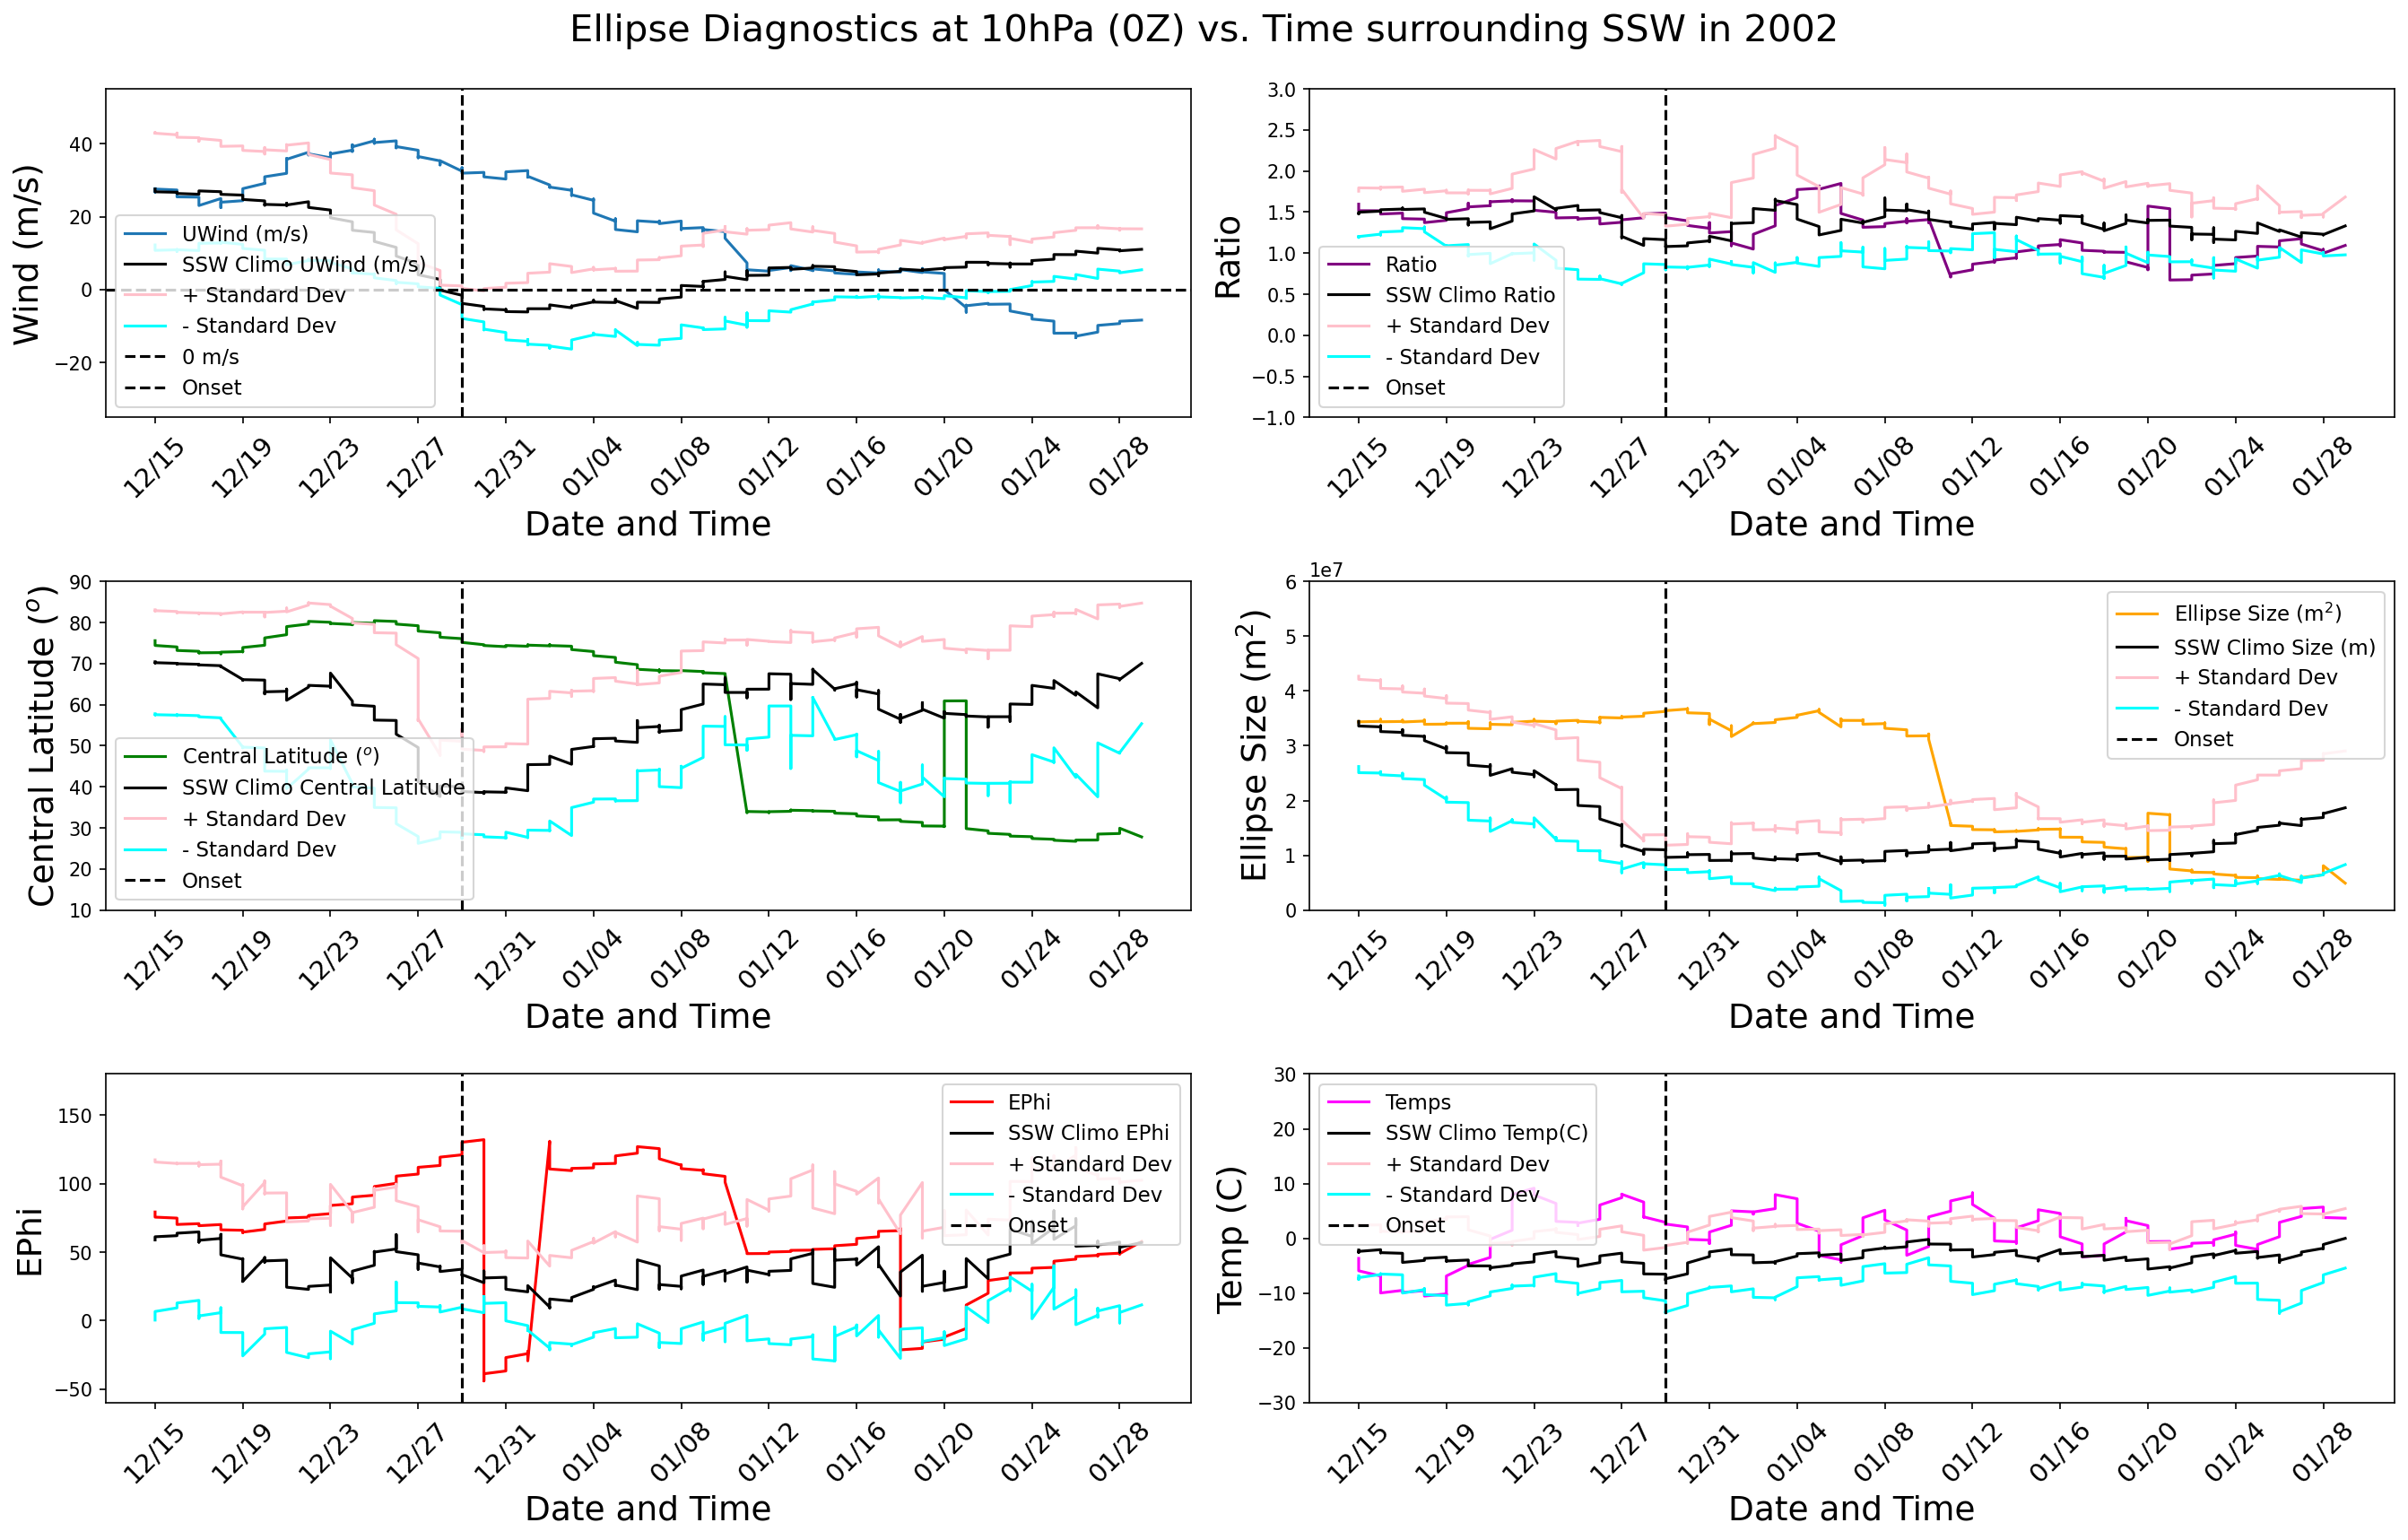

In [ ]:
##specific year:2013
myLocator = mticker.MultipleLocator(4)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()

y = str(year[1])
    
##diagnostics
    
w = e10[sswcl[1],int(dates[1][0]):int(dates[1][1])] #wind
rat = ephi_ratio10[sswcl[1],int(dates[1][0]):int(dates[1][1])]
cl = ephi_cenlat10[sswcl[1],int(dates[1][0]):int(dates[1][1])]
sz = ephi_size10[sswcl[1],int(dates[1][0]):int(dates[1][1])]
ep = ephi10[sswcl[1],int(dates[1][0]):int(dates[1][1])]
t = tem[sswcl[1],int(dates[1][0]):int(dates[1][1])]
    
x = normal_year[int(dates[1][0]):int(dates[1][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time surrounding SSW in 2013", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, label = "UWind (m/s)")
ax1.plot(x, sswwind10, label = "SSW Climo UWind (m/s)", color = "k")
ax1.plot(x, pos_sswwind, label = "+ Standard Dev", color = 'pink')
ax1.plot(x, neg_sswwind, label = "- Standard Dev", color = 'cyan')
ax1.axhline(y=0, color='k', linestyle='--', label = "0 m/s")
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-35,55)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, label = "Ratio", color = "purple")
ax2.plot(x, sswrat10, label = "SSW Climo Ratio", color = "k")
ax2.plot(x, pos_sswrat, label = "+ Standard Dev", color = 'pink')
ax2.plot(x, neg_sswrat, label = "- Standard Dev", color = 'cyan')
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, label = "Central Latitude ($^o$)", color = "green")
ax3.plot(x, sswcenl10, label = "SSW Climo Central Latitude", color = "k")
ax3.plot(x, pos_sswcenl, label = "+ Standard Dev", color = 'pink')
ax3.plot(x, neg_sswcenl, label = "- Standard Dev", color = 'cyan')
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, label = "Ellipse Size (m$^2$)", color = "orange")
ax4.plot(x, sswsize10, label = "SSW Climo Size (m)", color = "k")
ax4.plot(x, pos_sswsize, label = "+ Standard Dev", color = 'pink')
ax4.plot(x, neg_sswsize, label = "- Standard Dev", color = 'cyan')
ax4.set_ylabel("Ellipse Size (m$^2$)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, label = "EPhi", color = "red")
ax5.plot(x, sswep10, label = "SSW Climo EPhi", color = "k")
ax5.plot(x, pos_sswep, label = "+ Standard Dev", color = 'pink')
ax5.plot(x, neg_sswep, label = "- Standard Dev", color = 'cyan')
ax5.set_ylabel("EPhi", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, label = "Temps", color = "magenta")
ax6.set_ylabel("Temp (C)", fontsize = 18)
ax6.plot(x, sswt10, label = "SSW Climo Temp(C)", color = "k")
ax6.plot(x, pos_sswt, label = "+ Standard Dev", color = 'pink')
ax6.plot(x, neg_sswt, label = "- Standard Dev", color = 'cyan')
ax6.set_ylim(-30,30)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)
    
plt.xticks(rotation=45,fontsize = 14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


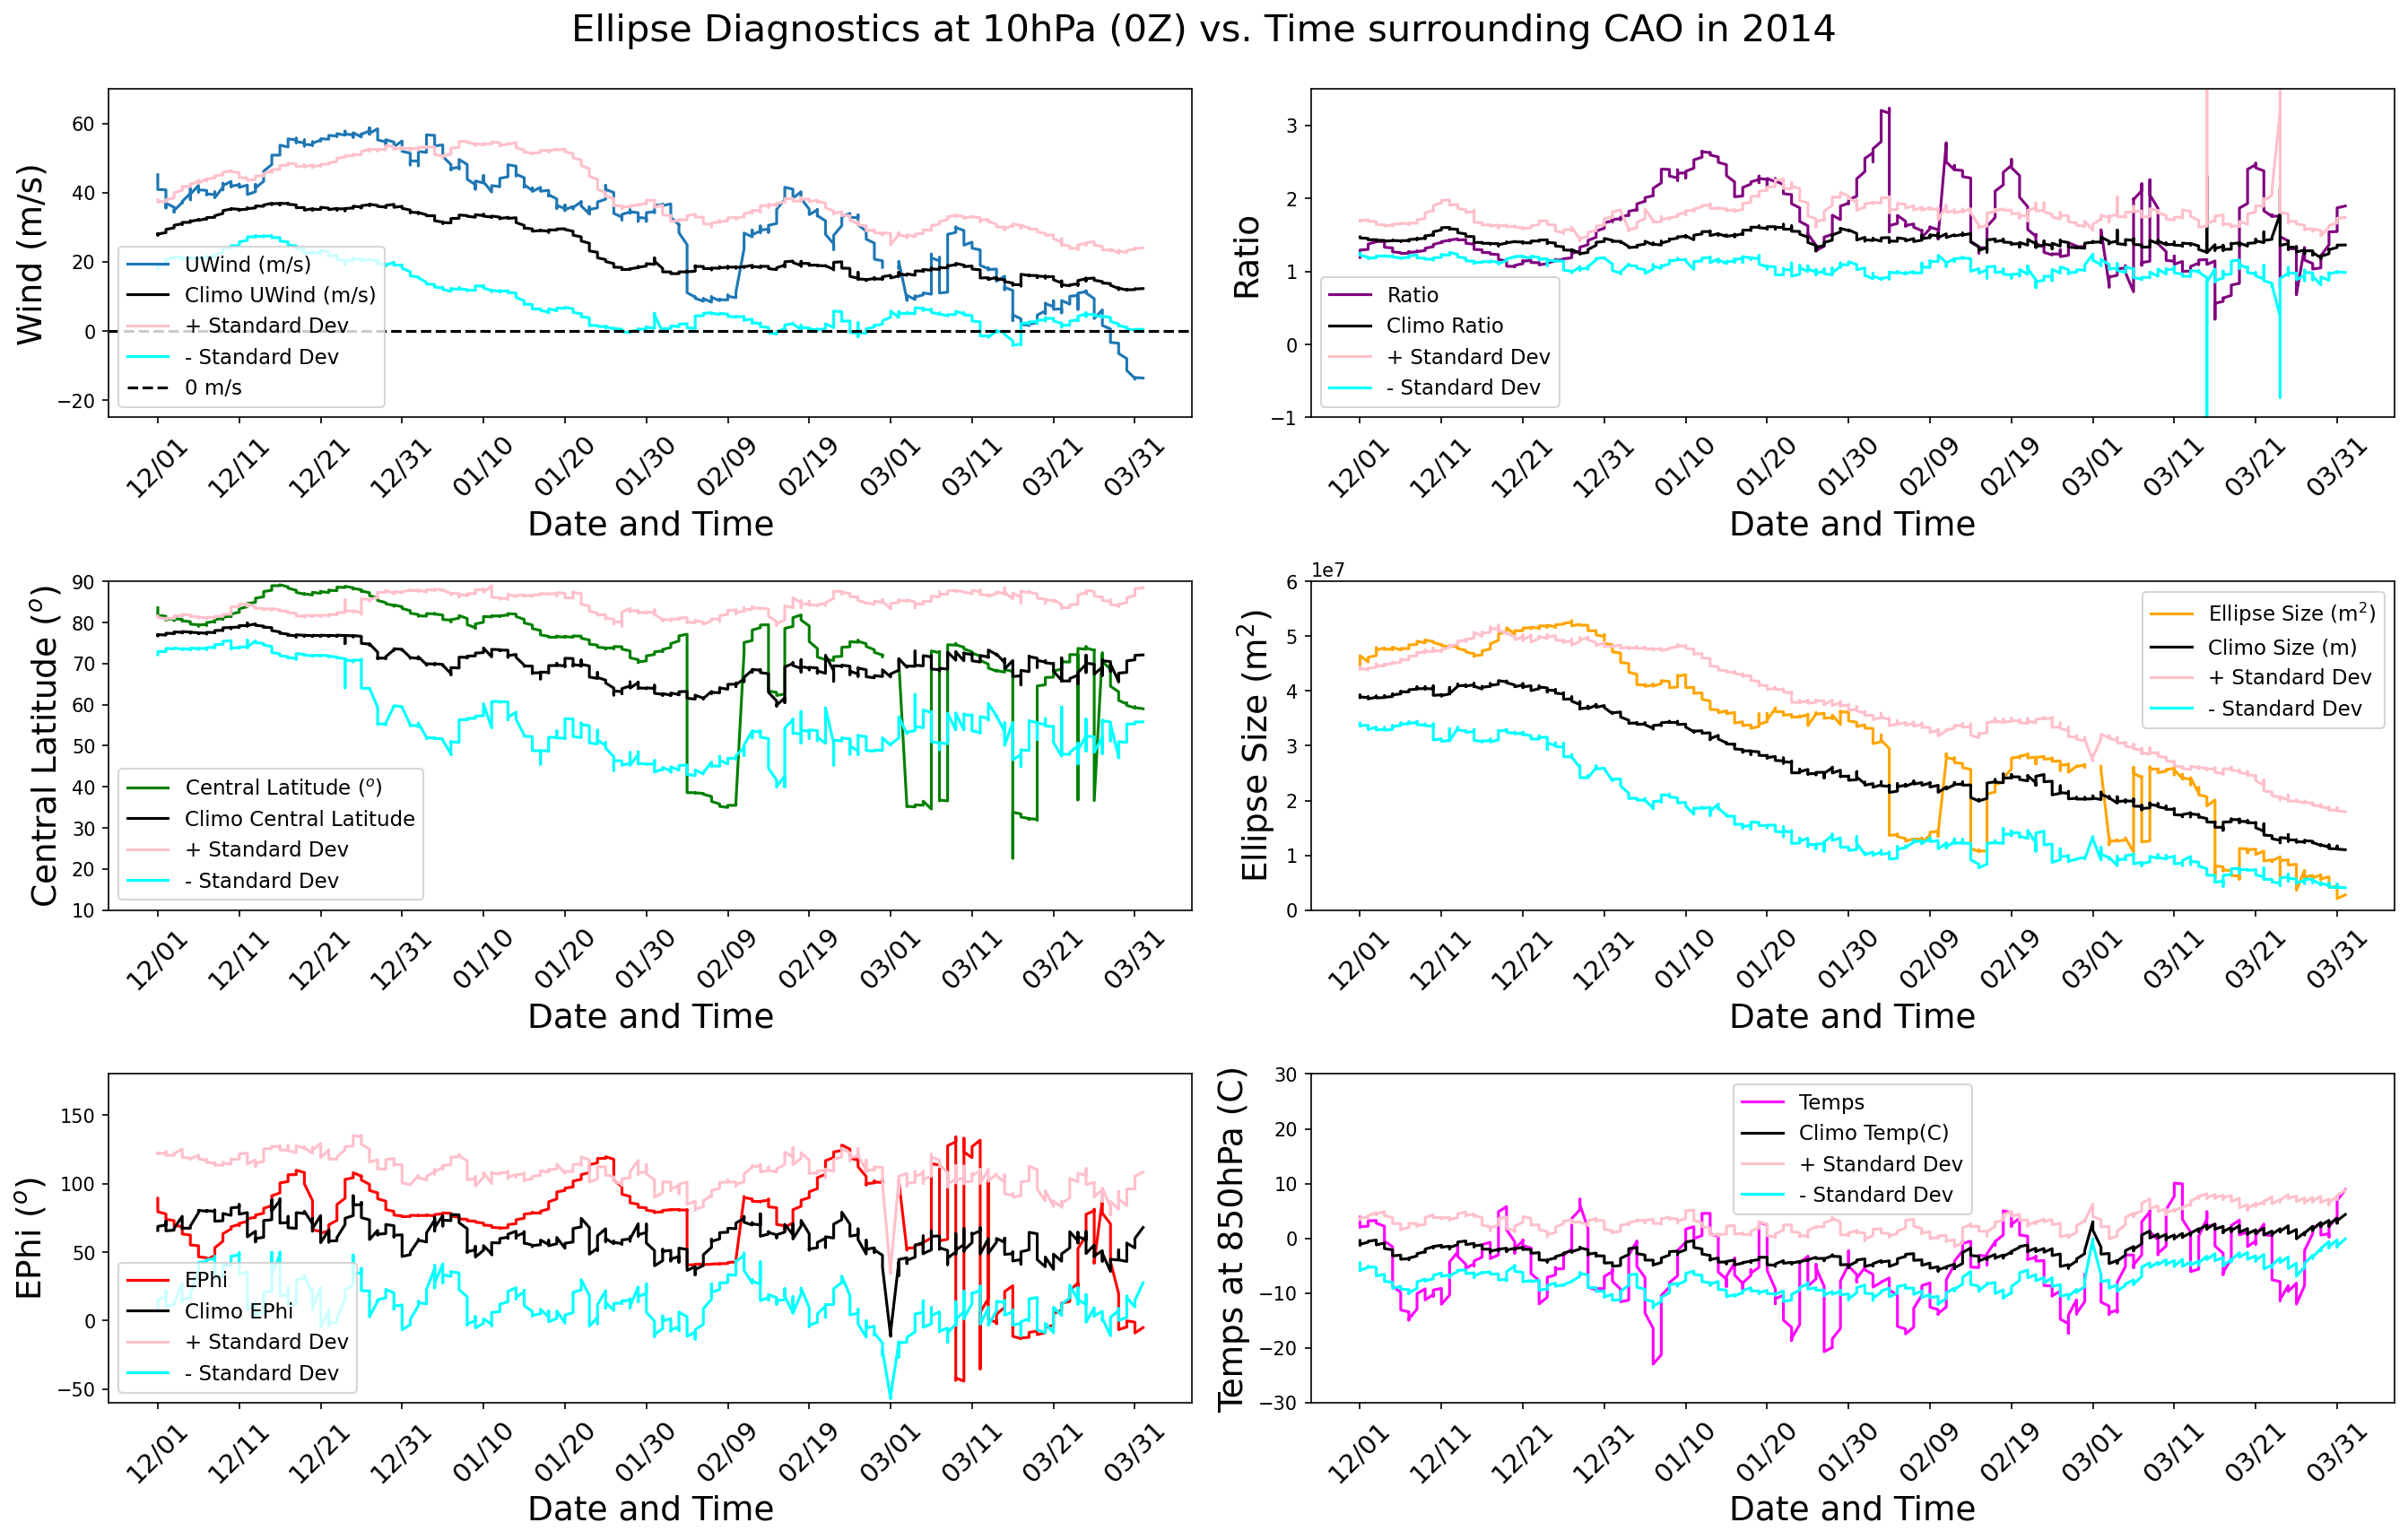

In [10]:
##specific year:2014
myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()

y = str(year[2])
    
##diagnostics
    
w = e10[sswcl[2],int(dates[2][0]):int(dates[2][1])] #wind
rat = ephi_ratio10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
cl = ephi_cenlat10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
sz = ephi_size10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
ep = ephi10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
t = tem[sswcl[2],int(dates[2][0]):int(dates[2][1])]
    
x = normal_year[int(dates[2][0]):int(dates[2][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time surrounding CAO in 2014", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, label = "UWind (m/s)")
ax1.plot(x, wind10[int(dates[2][0]):int(dates[2][1])], label = "Climo UWind (m/s)", color = "k")
ax1.plot(x, pos_wind[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax1.plot(x, neg_wind[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax1.axhline(y=0, color='k', label = "0 m/s", linestyle='--')
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-25,70)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, label = "Ratio", color = "purple")
ax2.plot(x, rat10[int(dates[2][0]):int(dates[2][1])], label = "Climo Ratio", color = "k")
ax2.plot(x, pos_rat[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax2.plot(x, neg_rat[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3.5)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[39], color='k', linestyle='--')
plt.legend(fontsize = 11)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, label = "Central Latitude ($^o$)", color = "green")
ax3.plot(x, cenl10[int(dates[2][0]):int(dates[2][1])], label = "Climo Central Latitude", color = "k")
ax3.plot(x, pos_cenl[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax3.plot(x, neg_cenl[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, label = "Ellipse Size (m$^2$)", color = "orange")
ax4.plot(x, size10[int(dates[2][0]):int(dates[2][1])], label = "Climo Size (m)", color = "k")
ax4.plot(x, pos_size[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax4.plot(x, neg_size[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax4.set_ylabel("Ellipse Size (m$^2$)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, label = "EPhi", color = "red")
ax5.plot(x, ep10[int(dates[2][0]):int(dates[2][1])], label = "Climo EPhi", color = "k")
ax5.plot(x, pos_ep[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax5.plot(x, neg_ep[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax5.set_ylabel("EPhi ($^o$)", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, label = "Temps", color = "magenta")
ax6.plot(x, tem10[int(dates[2][0]):int(dates[2][1])], label = "Climo Temp(C)", color = "k")
ax6.plot(x, pos_t[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax6.plot(x, neg_t[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax6.set_ylabel("Temps at 850hPa (C)", fontsize = 18)
ax6.set_ylim(-30,30)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[39], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 11)
    
plt.xticks(rotation=45,fontsize = 14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


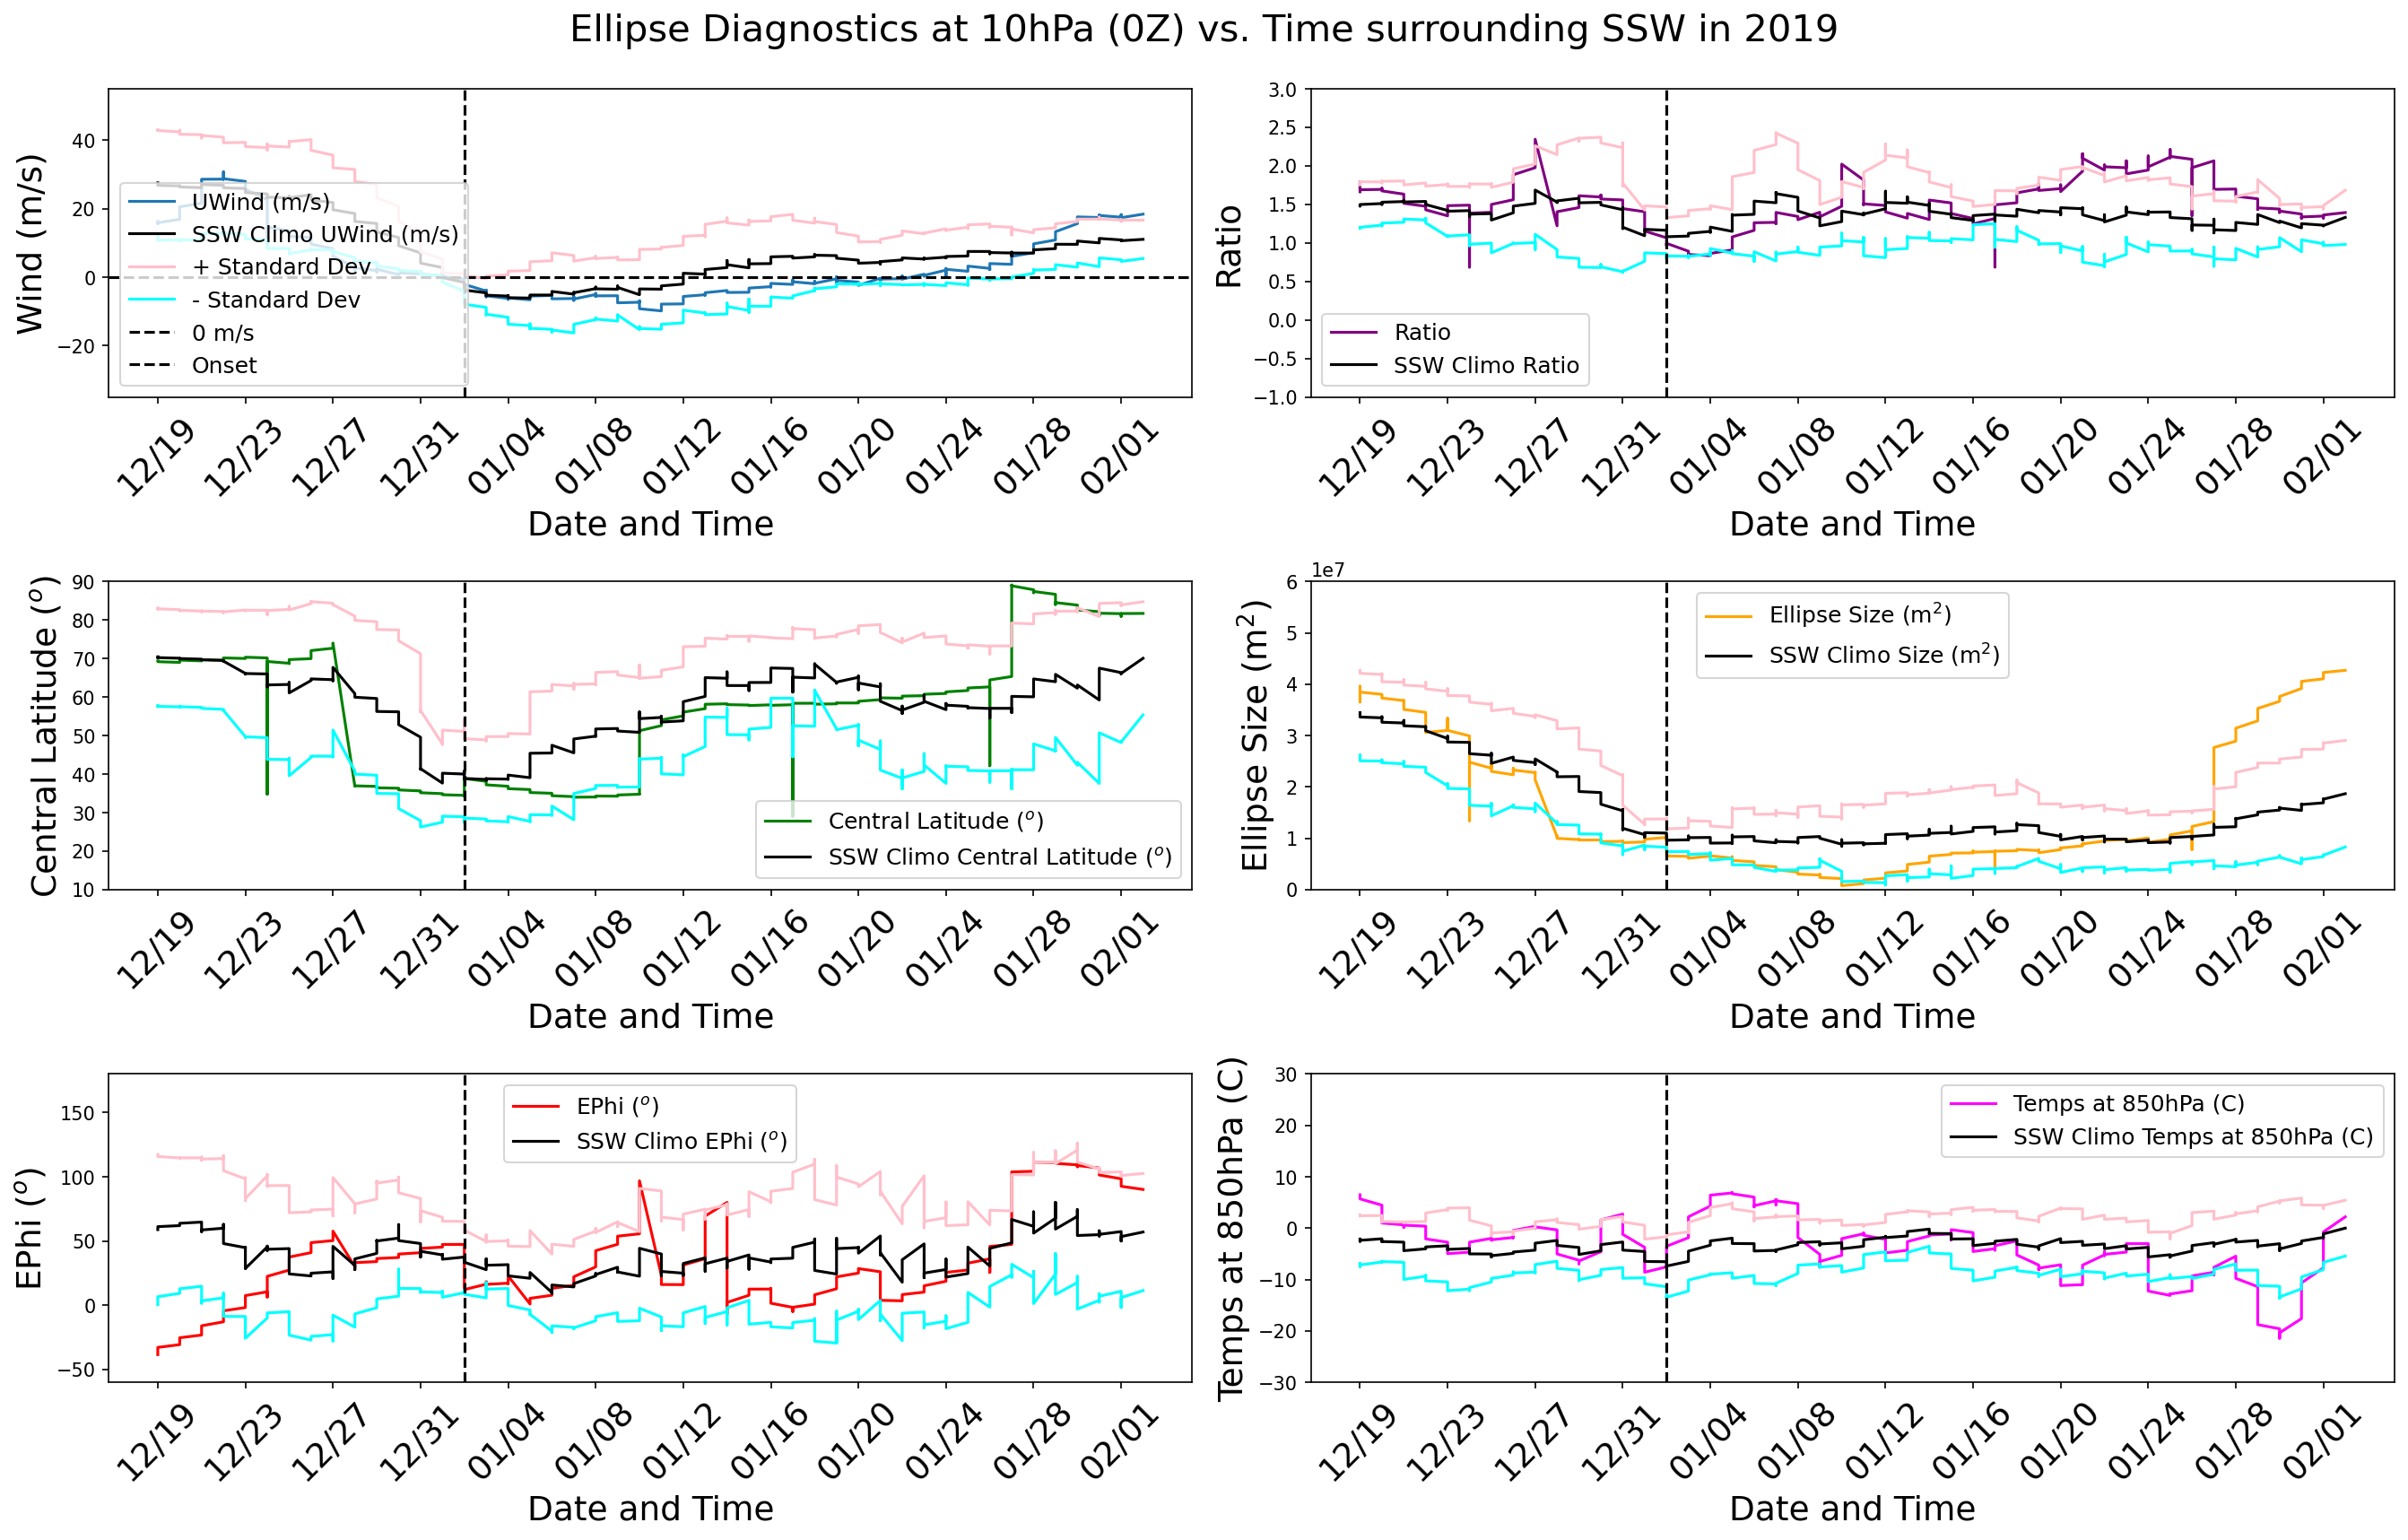

In [25]:
##specific year:2019
myLocator = mticker.MultipleLocator(4)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()

y = str(year[3])
    
##diagnostics
    
w = e10[sswcl[3],int(dates[3][0]):int(dates[3][1])] #wind
rat = ephi_ratio10[sswcl[3],int(dates[3][0]):int(dates[3][1])]
cl = ephi_cenlat10[sswcl[3],int(dates[3][0]):int(dates[3][1])]
sz = ephi_size10[sswcl[3],int(dates[3][0]):int(dates[3][1])]
ep = ephi10[sswcl[3],int(dates[3][0]):int(dates[3][1])]
t = tem[sswcl[3],int(dates[3][0]):int(dates[3][1])]
    
x = normal_year[int(dates[3][0]):int(dates[3][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time surrounding SSW in 2019", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, label = "UWind (m/s)")
ax1.plot(x, sswwind10, label = "SSW Climo UWind (m/s)", color = "k")
ax1.plot(x, pos_sswwind, label = "+ Standard Dev", color = 'pink')
ax1.plot(x, neg_sswwind, label = "- Standard Dev", color = 'cyan')
ax1.axhline(y=0, color='k', linestyle='--', label = "0 m/s")
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-35,55)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
plt.axvline(x=x[59], color='k', linestyle='--',label = "Onset")
plt.legend(fontsize = 12)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, label = "Ratio", color = "purple")
ax2.plot(x, sswrat10, label = "SSW Climo Ratio", color = "k")
ax2.plot(x, pos_sswrat, color = 'pink')
ax2.plot(x, neg_sswrat, color = 'cyan')
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
plt.axvline(x=x[59], color='k', linestyle='--')
plt.legend(fontsize = 12)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, label = "Central Latitude ($^o$)", color = "green")
ax3.plot(x, sswcenl10, label = "SSW Climo Central Latitude ($^o$)", color = "k")
ax3.plot(x, pos_sswcenl, color = 'pink')
ax3.plot(x, neg_sswcenl, color = 'cyan')
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
plt.axvline(x=x[59], color='k', linestyle='--')
plt.legend(fontsize = 12)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, label = "Ellipse Size (m$^2$)", color = "orange")
ax4.plot(x, sswsize10, label = "SSW Climo Size (m$^2$)", color = "k")
ax4.plot(x, pos_sswsize, color = 'pink')
ax4.plot(x, neg_sswsize, color = 'cyan')
ax4.set_ylabel("Ellipse Size (m$^2$)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
plt.axvline(x=x[59], color='k', linestyle='--')
plt.legend(fontsize = 12)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, label = "EPhi ($^o$)", color = "red")
ax5.plot(x, sswep10, label = "SSW Climo EPhi ($^o$)", color = "k")
ax5.plot(x, pos_sswep, color = 'pink')
ax5.plot(x, neg_sswep, color = 'cyan')
ax5.set_ylabel("EPhi ($^o$)", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
plt.axvline(x=x[59], color='k', linestyle='--')
plt.legend(fontsize = 12)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, label = "Temps at 850hPa (C)", color = "magenta")
ax6.set_ylabel("Temps at 850hPa (C)", fontsize = 18)
ax6.plot(x, sswt10, label = "SSW Climo Temps at 850hPa (C)", color = "k")
ax6.plot(x, pos_sswt, color = 'pink')
ax6.plot(x, neg_sswt, color = 'cyan')
ax6.set_ylim(-30,30)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 18)
plt.axvline(x=x[59], color='k', linestyle='--')
plt.legend(fontsize = 12)
    
plt.xticks(rotation=45,fontsize = 18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Time_2019SSW.png")


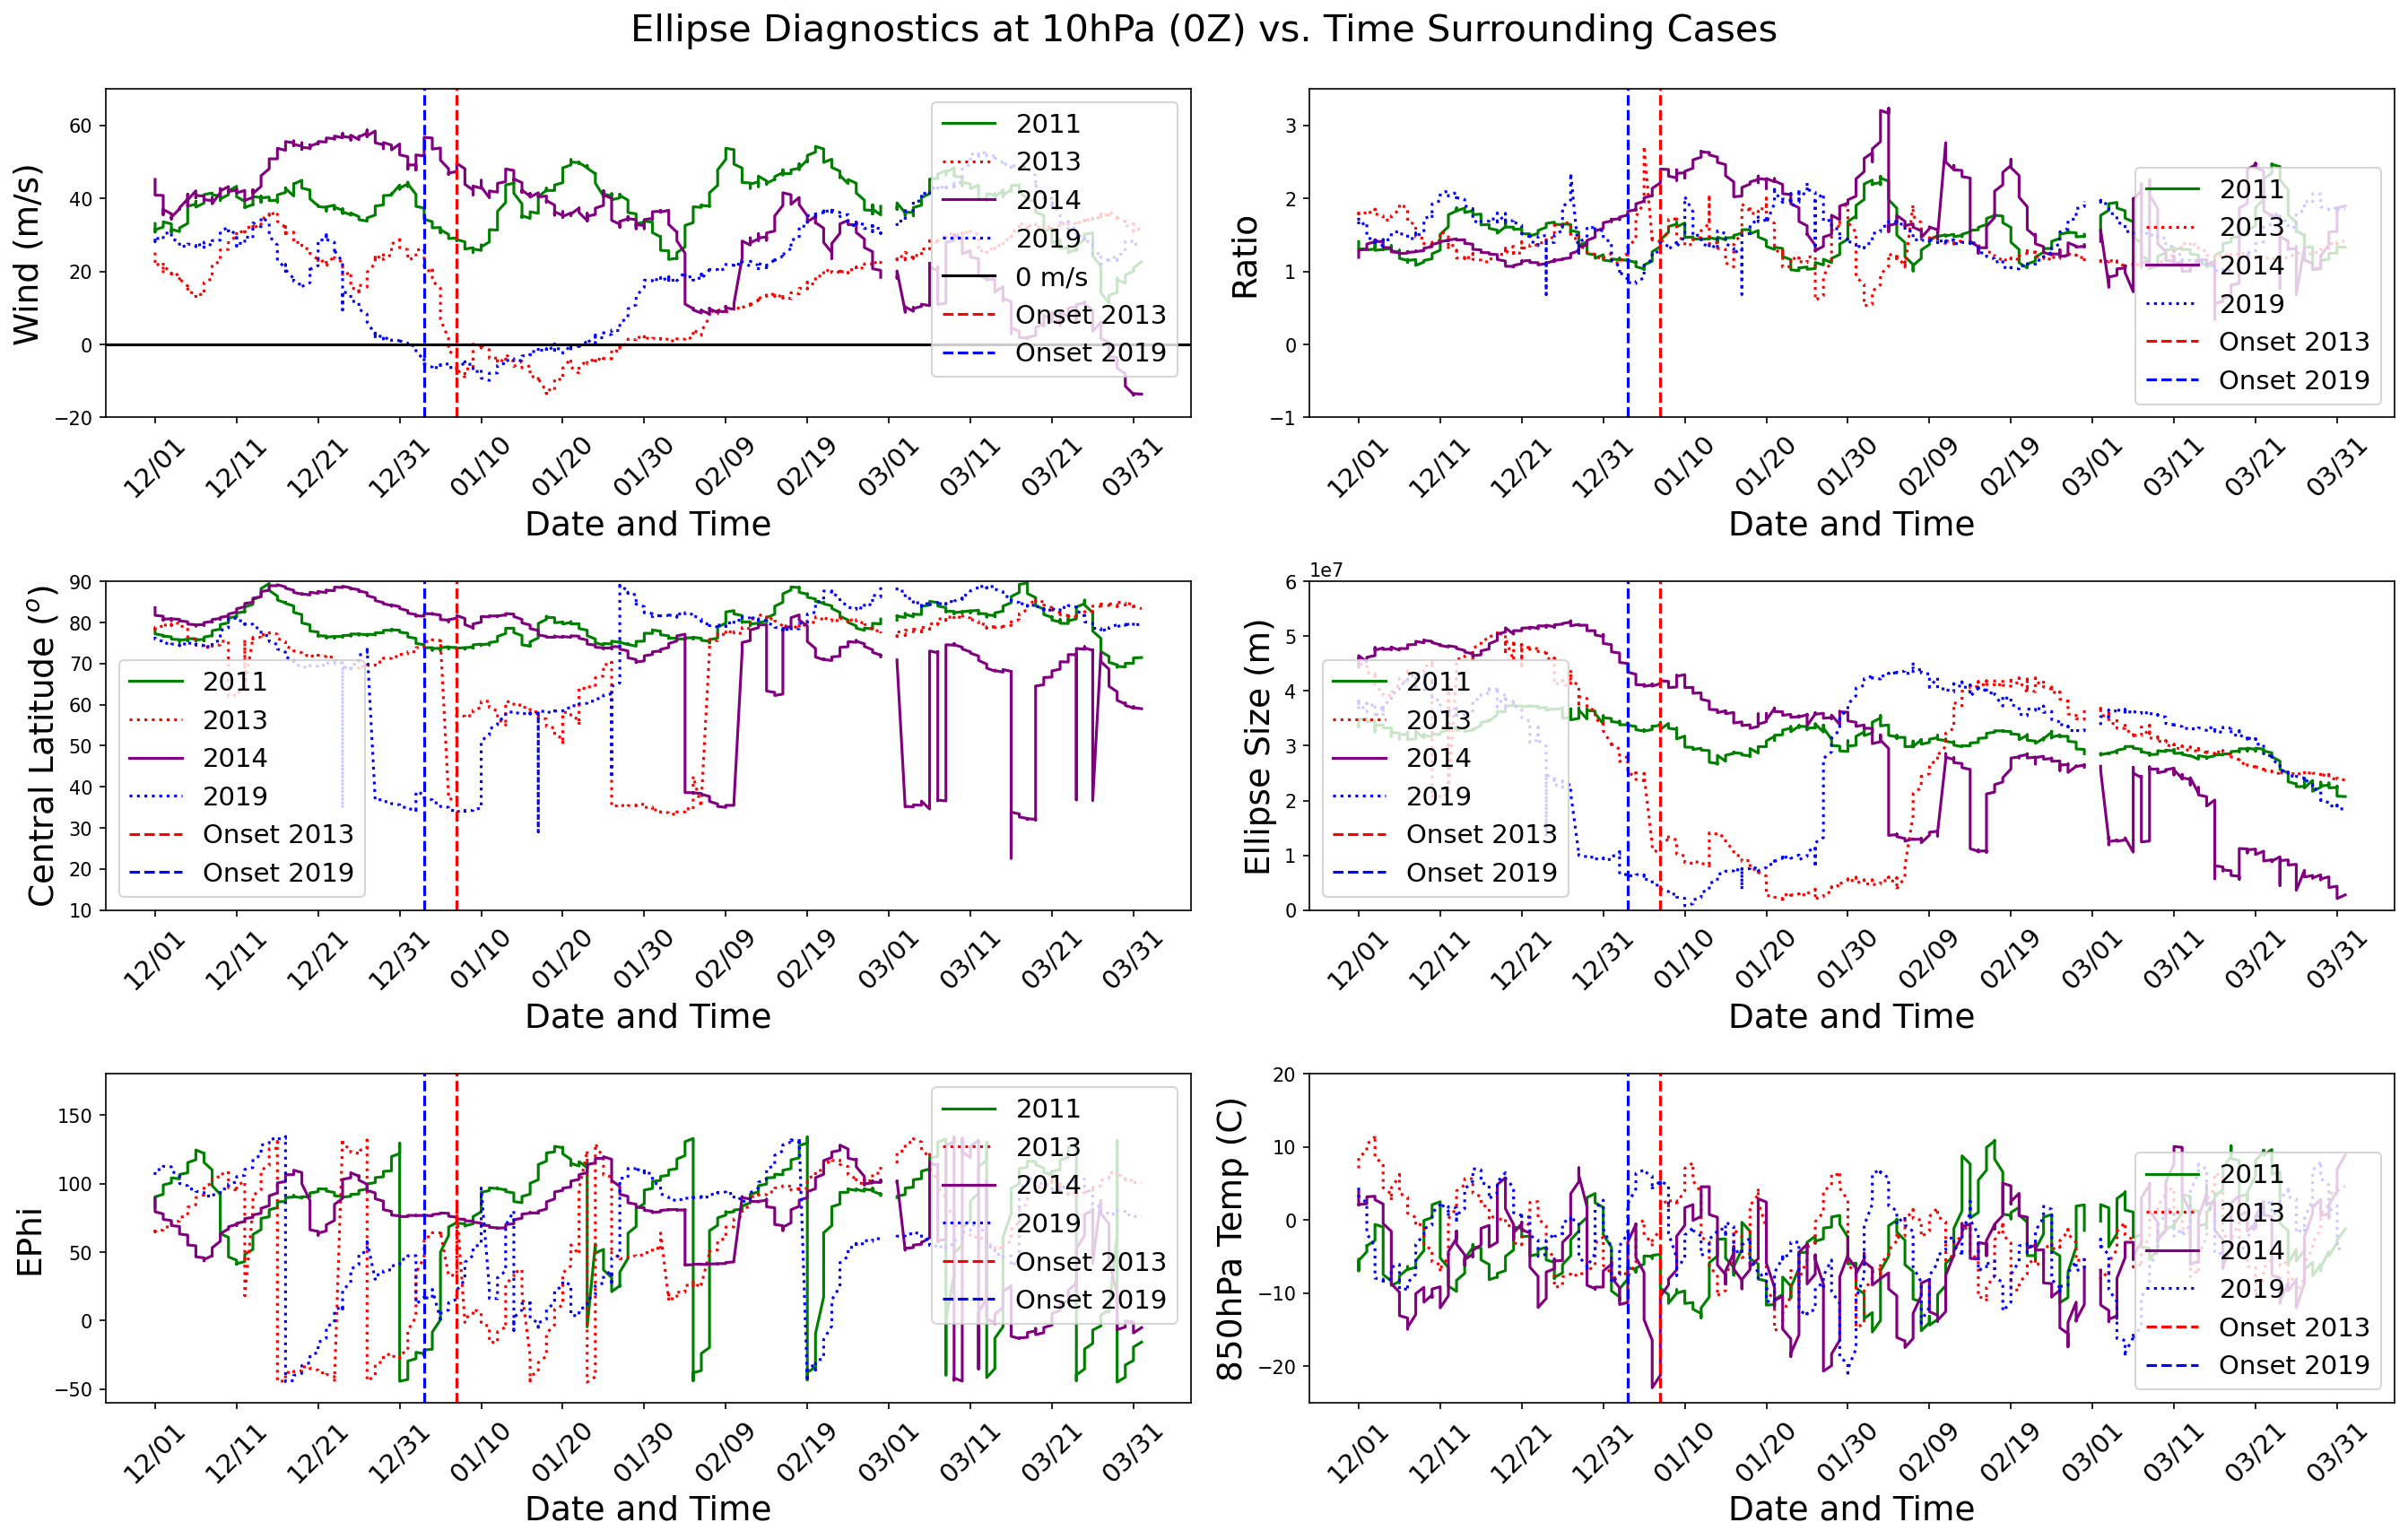

In [12]:
##specific year:2014
myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()
    
##diagnostics
##2011
w = e10[sswcl[0],int(dates[0][0]):int(dates[0][1])] #wind
rat = ephi_ratio10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
cl = ephi_cenlat10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
sz = ephi_size10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
ep = ephi10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
t = tem[sswcl[0],int(dates[0][0]):int(dates[0][1])]

##2013
w2 = e10[sswcl[1],int(dates[0][0]):int(dates[0][1])] #wind
rat2 = ephi_ratio10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
cl2 = ephi_cenlat10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
sz2 = ephi_size10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
ep2 = ephi10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
t2 = tem[sswcl[1],int(dates[0][0]):int(dates[0][1])]

##2014
w3 = e10[sswcl[2],int(dates[2][0]):int(dates[2][1])] #wind
rat3 = ephi_ratio10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
cl3 = ephi_cenlat10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
sz3 = ephi_size10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
ep3 = ephi10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
t3 = tem[sswcl[2],int(dates[2][0]):int(dates[2][1])]

##2019
w4 = e10[sswcl[3],int(dates[2][0]):int(dates[2][1])] #wind
rat4 = ephi_ratio10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
cl4 = ephi_cenlat10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
sz4 = ephi_size10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
ep4 = ephi10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
t4 = tem[sswcl[3],int(dates[2][0]):int(dates[2][1])]
    
x = normal_year[int(dates[2][0]):int(dates[2][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time Surrounding Cases", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, linestyle = 'solid', color = 'green', label = "2011")
ax1.plot(x, w2, linestyle = 'dotted', color = 'red', label = "2013")
ax1.plot(x, w3, linestyle = 'solid',  color = 'purple', label = "2014")
ax1.plot(x, w4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax1.axhline(y=0, color='k', linestyle='-', label = "0 m/s")
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-20,70)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, linestyle = 'solid', color = 'green', label = "2011")
ax2.plot(x, rat2, linestyle = 'dotted', color = 'red', label = "2013")
ax2.plot(x, rat3, linestyle = 'solid',  color = 'purple', label = "2014")
ax2.plot(x, rat4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3.5)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, linestyle = 'solid', color = 'green', label = "2011")
ax3.plot(x, cl2, linestyle = 'dotted', color = 'red', label = "2013")
ax3.plot(x, cl3, linestyle = 'solid',  color = 'purple', label = "2014")
ax3.plot(x, cl4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, linestyle = 'solid', color = 'green', label = "2011")
ax4.plot(x, sz2, linestyle = 'dotted', color = 'red', label = "2013")
ax4.plot(x, sz3, linestyle = 'solid',  color = 'purple', label = "2014")
ax4.plot(x, sz4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax4.set_ylabel("Ellipse Size (m)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, linestyle = 'solid', color = 'green', label = "2011")
ax5.plot(x, ep2, linestyle = 'dotted', color = 'red', label = "2013")
ax5.plot(x, ep3, linestyle = 'solid',  color = 'purple', label = "2014")
ax5.plot(x, ep4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax5.set_ylabel("EPhi", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, linestyle = 'solid', color = 'green', label = "2011")
ax6.plot(x, t2, linestyle = 'dotted', color = 'red', label = "2013")
ax6.plot(x, t3, linestyle = 'solid',  color = 'purple', label = "2014")
ax6.plot(x, t4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax6.set_ylabel("850hPa Temp (C)", fontsize = 18)
ax6.set_ylim(-25,20)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)
    
plt.xticks(rotation=45,fontsize = 14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



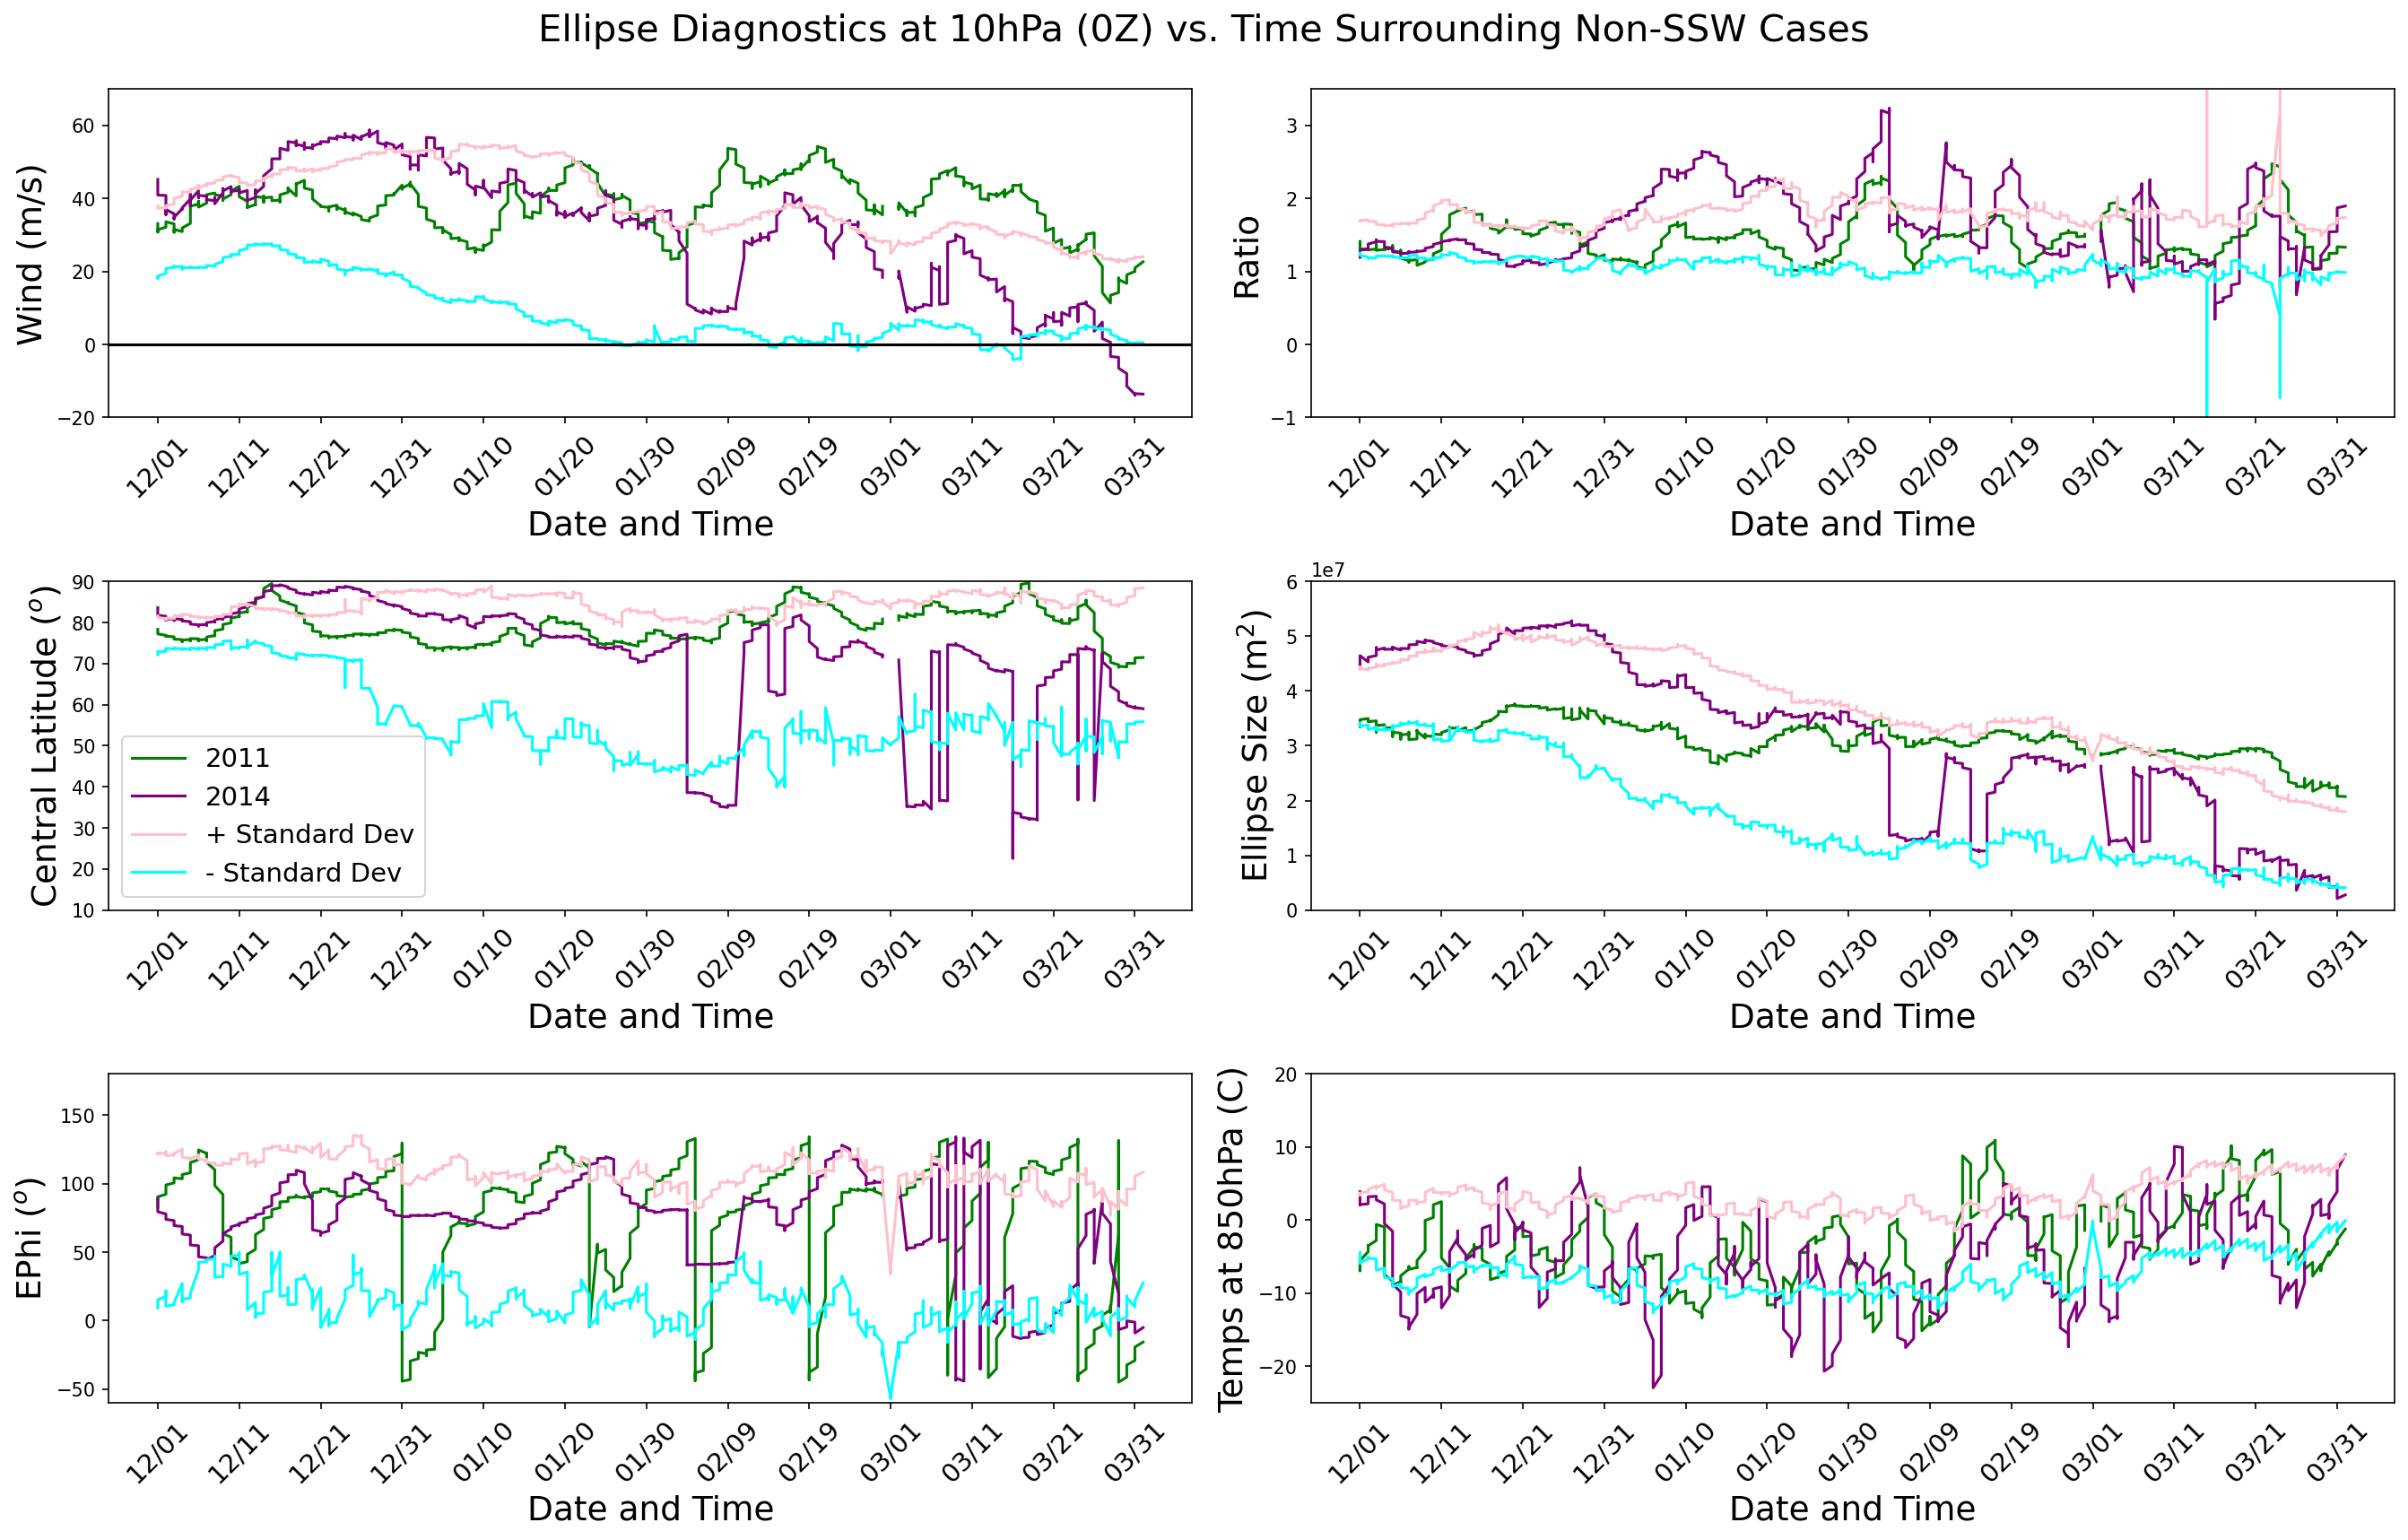

In [13]:
##specific year:2014
myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()
    
##diagnostics
##2011
w = e10[sswcl[0],int(dates[0][0]):int(dates[0][1])] #wind
rat = ephi_ratio10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
cl = ephi_cenlat10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
sz = ephi_size10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
ep = ephi10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
t = tem[sswcl[0],int(dates[0][0]):int(dates[0][1])]

##2013
w2 = e10[sswcl[1],int(dates[0][0]):int(dates[0][1])] #wind
rat2 = ephi_ratio10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
cl2 = ephi_cenlat10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
sz2 = ephi_size10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
ep2 = ephi10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
t2 = tem[sswcl[1],int(dates[0][0]):int(dates[0][1])]

##2014
w3 = e10[sswcl[2],int(dates[2][0]):int(dates[2][1])] #wind
rat3 = ephi_ratio10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
cl3 = ephi_cenlat10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
sz3 = ephi_size10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
ep3 = ephi10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
t3 = tem[sswcl[2],int(dates[2][0]):int(dates[2][1])]

##2019
w4 = e10[sswcl[3],int(dates[2][0]):int(dates[2][1])] #wind
rat4 = ephi_ratio10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
cl4 = ephi_cenlat10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
sz4 = ephi_size10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
ep4 = ephi10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
t4 = tem[sswcl[3],int(dates[2][0]):int(dates[2][1])]
    
x = normal_year[int(dates[2][0]):int(dates[2][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time Surrounding Non-SSW Cases", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, linestyle = 'solid', color = 'green', label = "2011")
#ax1.plot(x, w2, linestyle = 'dotted', color = 'red', label = "2013")
ax1.plot(x, w3, linestyle = 'solid',  color = 'purple', label = "2014")
#ax1.plot(x, w4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax1.plot(x, pos_wind[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax1.plot(x, neg_wind[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax1.axhline(y=0, color='k', linestyle='-', label = "0 m/s")
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-20,70)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
#plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
#plt.legend(fontsize = 14)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, linestyle = 'solid', color = 'green', label = "2011")
#ax2.plot(x, rat2, linestyle = 'dotted', color = 'red', label = "2013")
ax2.plot(x, rat3, linestyle = 'solid',  color = 'purple', label = "2014")
ax2.plot(x, pos_rat[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax2.plot(x, neg_rat[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
#ax2.plot(x, rat4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3.5)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
#plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
#plt.legend(fontsize = 14)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, linestyle = 'solid', color = 'green', label = "2011")
#ax3.plot(x, cl2, linestyle = 'dotted', color = 'red', label = "2013")
ax3.plot(x, cl3, linestyle = 'solid',  color = 'purple', label = "2014")
#ax3.plot(x, cl4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax3.plot(x, pos_cenl[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax3.plot(x, neg_cenl[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
#plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, linestyle = 'solid', color = 'green', label = "2011")
#ax4.plot(x, sz2, linestyle = 'dotted', color = 'red', label = "2013")
ax4.plot(x, sz3, linestyle = 'solid',  color = 'purple', label = "2014")
#ax4.plot(x, sz4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax4.plot(x, pos_size[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax4.plot(x, neg_size[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax4.set_ylabel("Ellipse Size (m$^2$)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
#plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
#plt.legend(fontsize = 14)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, linestyle = 'solid', color = 'green', label = "2011")
#ax5.plot(x, ep2, linestyle = 'dotted', color = 'red', label = "2013")
ax5.plot(x, ep3, linestyle = 'solid',  color = 'purple', label = "2014")
#ax5.plot(x, ep4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax5.plot(x, pos_ep[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax5.plot(x, neg_ep[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax5.set_ylabel("EPhi ($^o$)", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
#plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
#plt.legend(fontsize = 14)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, linestyle = 'solid', color = 'green', label = "2011")
#ax6.plot(x, t2, linestyle = 'dotted', color = 'red', label = "2013")
ax6.plot(x, t3, linestyle = 'solid',  color = 'purple', label = "2014")
#ax6.plot(x, t4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax6.plot(x, pos_t[int(dates[2][0]):int(dates[2][1])], label = "+ Standard Dev", color = 'pink')
ax6.plot(x, neg_t[int(dates[2][0]):int(dates[2][1])], label = "- Standard Dev", color = 'cyan')
ax6.set_ylabel("Temps at 850hPa (C)", fontsize = 18)
ax6.set_ylim(-25,20)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
#plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
#plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
#plt.legend(fontsize = 14)
    
plt.xticks(rotation=45,fontsize = 14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Time_20142011.png")


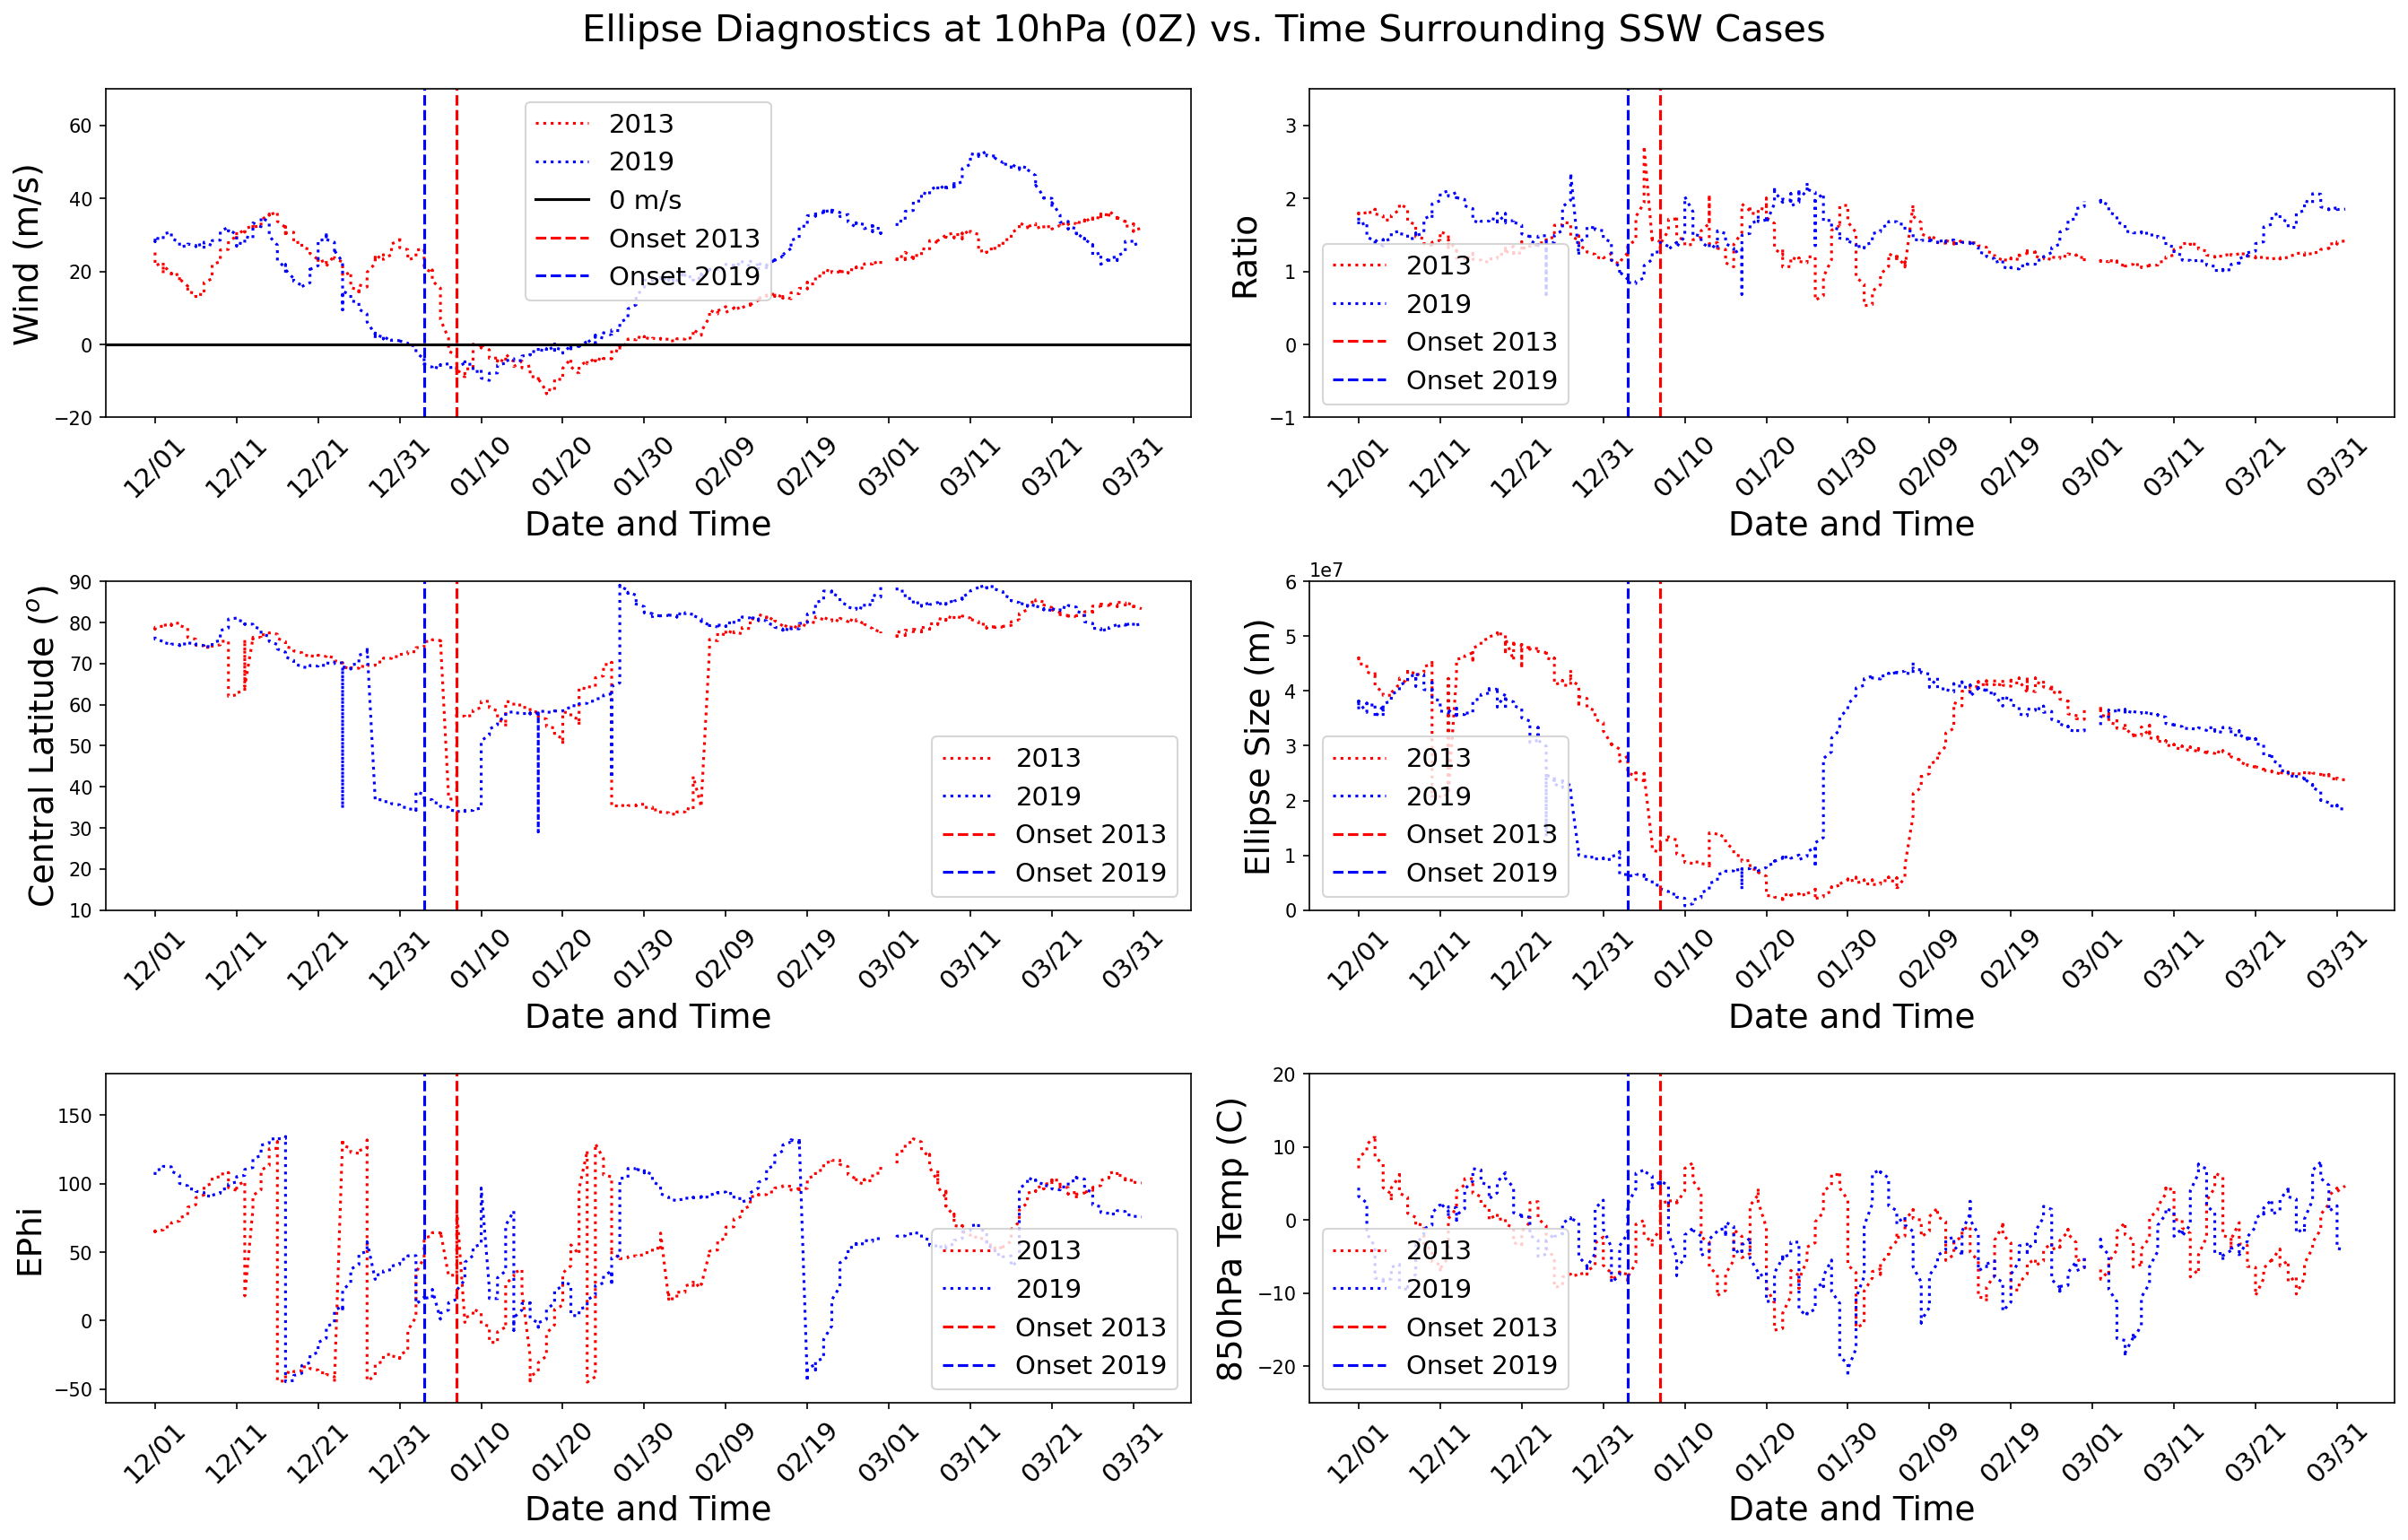

In [14]:
##specific year:2014
myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()
    
##diagnostics
##2011
w = e10[sswcl[0],int(dates[0][0]):int(dates[0][1])] #wind
rat = ephi_ratio10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
cl = ephi_cenlat10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
sz = ephi_size10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
ep = ephi10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
t = tem[sswcl[0],int(dates[0][0]):int(dates[0][1])]

##2013
w2 = e10[sswcl[1],int(dates[0][0]):int(dates[0][1])] #wind
rat2 = ephi_ratio10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
cl2 = ephi_cenlat10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
sz2 = ephi_size10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
ep2 = ephi10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
t2 = tem[sswcl[1],int(dates[0][0]):int(dates[0][1])]

##2014
w3 = e10[sswcl[2],int(dates[2][0]):int(dates[2][1])] #wind
rat3 = ephi_ratio10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
cl3 = ephi_cenlat10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
sz3 = ephi_size10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
ep3 = ephi10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
t3 = tem[sswcl[2],int(dates[2][0]):int(dates[2][1])]

##2019
w4 = e10[sswcl[3],int(dates[2][0]):int(dates[2][1])] #wind
rat4 = ephi_ratio10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
cl4 = ephi_cenlat10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
sz4 = ephi_size10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
ep4 = ephi10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
t4 = tem[sswcl[3],int(dates[2][0]):int(dates[2][1])]
    
x = normal_year[int(dates[2][0]):int(dates[2][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time Surrounding SSW Cases", fontsize = 20)

ax1 = plt.subplot(3,2,1)
#ax1.plot(x, w, linestyle = 'solid', color = 'green', label = "2011")
ax1.plot(x, w2, linestyle = 'dotted', color = 'red', label = "2013")
#ax1.plot(x, w3, linestyle = 'solid',  color = 'purple', label = "2014")
ax1.plot(x, w4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax1.axhline(y=0, color='k', linestyle='-', label = "0 m/s")
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-20,70)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax2 = plt.subplot(3,2,2)
#ax2.plot(x, rat, linestyle = 'solid', color = 'green', label = "2011")
ax2.plot(x, rat2, linestyle = 'dotted', color = 'red', label = "2013")
#ax2.plot(x, rat3, linestyle = 'solid',  color = 'purple', label = "2014")
ax2.plot(x, rat4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3.5)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)
    
ax3 = plt.subplot(3,2,3)
#ax3.plot(x, cl, linestyle = 'solid', color = 'green', label = "2011")
ax3.plot(x, cl2, linestyle = 'dotted', color = 'red', label = "2013")
#ax3.plot(x, cl3, linestyle = 'solid',  color = 'purple', label = "2014")
ax3.plot(x, cl4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax4 = plt.subplot(3,2,4)
#ax4.plot(x, sz, linestyle = 'solid', color = 'green', label = "2011")
ax4.plot(x, sz2, linestyle = 'dotted', color = 'red', label = "2013")
#ax4.plot(x, sz3, linestyle = 'solid',  color = 'purple', label = "2014")
ax4.plot(x, sz4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax4.set_ylabel("Ellipse Size (m)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax5 = plt.subplot(3,2,5)
#ax5.plot(x, ep, linestyle = 'solid', color = 'green', label = "2011")
ax5.plot(x, ep2, linestyle = 'dotted', color = 'red', label = "2013")
#ax5.plot(x, ep3, linestyle = 'solid',  color = 'purple', label = "2014")
ax5.plot(x, ep4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax5.set_ylabel("EPhi", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax6 = plt.subplot(3,2,6)
#ax6.plot(x, t, linestyle = 'solid', color = 'green', label = "2011")
ax6.plot(x, t2, linestyle = 'dotted', color = 'red', label = "2013")
#ax6.plot(x, t3, linestyle = 'solid',  color = 'purple', label = "2014")
ax6.plot(x, t4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax6.set_ylabel("850hPa Temp (C)", fontsize = 18)
ax6.set_ylim(-25,20)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)
    
plt.xticks(rotation=45,fontsize = 14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [15]:
##Open temp related pickles
infile = open("10save_time.p",'rb')
year_ref10 = pickle.load(infile)
infile.close()

infile = open("10save.p",'rb')
temp_ref10 = pickle.load(infile)
infile.close()

infile = open("10lats.p",'rb')
lats10 = pickle.load(infile)
infile.close()

infile = open("10lons.p",'rb')
lons10 = pickle.load(infile)
infile.close()

In [16]:
## averaging temp values in grid
tempval = np.empty((20,488,64,134))
tempval[:] = np.nan

yearnot = 0

for i in np.arange(1999,2019): 
    #print(i)
    #print(yearnot)
    year_save = temp_ref10[np.where(year_ref10==i)]
    #print(year_save.shape)
    if i == 1999 or i == 2003 or i == 2007 or i == 2011 or i ==2015: #account for leap years in entering data
        tempval[yearnot,:,:,:] = year_save
        yearnot = yearnot+1
    else:
        tempval[yearnot,0:360,:,:] = year_save[0:360,:,:]
        tempval[yearnot,364:,:,:] = year_save[360:,:,:]
        yearnot = yearnot+1

tempvals10 = tempval[:,:,23:39,81:117]
print(tempvals.shape)

(20, 488, 16, 36)


In [17]:
#Average temperature
#first along lons
temps10 = np.nanmean(tempvals10,axis=3)
temps10 = np.nanmean(temps10,axis=2)

print(temps10.shape)
tem10 = temps10-273.15 #convert to C

print(tem10)

(20, 488)
[[-55.27419468 -55.36545071 -56.31160244 ... -50.79561378 -51.79194658
  -50.58172031]
 [-54.35681763 -55.15938246 -55.73295865 ... -43.92738274 -45.40913323
  -43.37909376]
 [-61.0132999  -62.12335476 -64.24336853 ... -43.28678996 -44.51629062
  -41.41055569]
 ...
 [-55.97329644 -56.26503771 -56.21863403 ... -50.78872104 -50.7458252
  -50.35475769]
 [-61.59976976 -60.7213111  -61.52708367 ... -50.73532376 -50.87993978
  -50.5043769 ]
 [-57.58928189 -57.45807665 -56.68500366 ... -45.06229248 -43.33462626
  -42.5229994 ]]


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


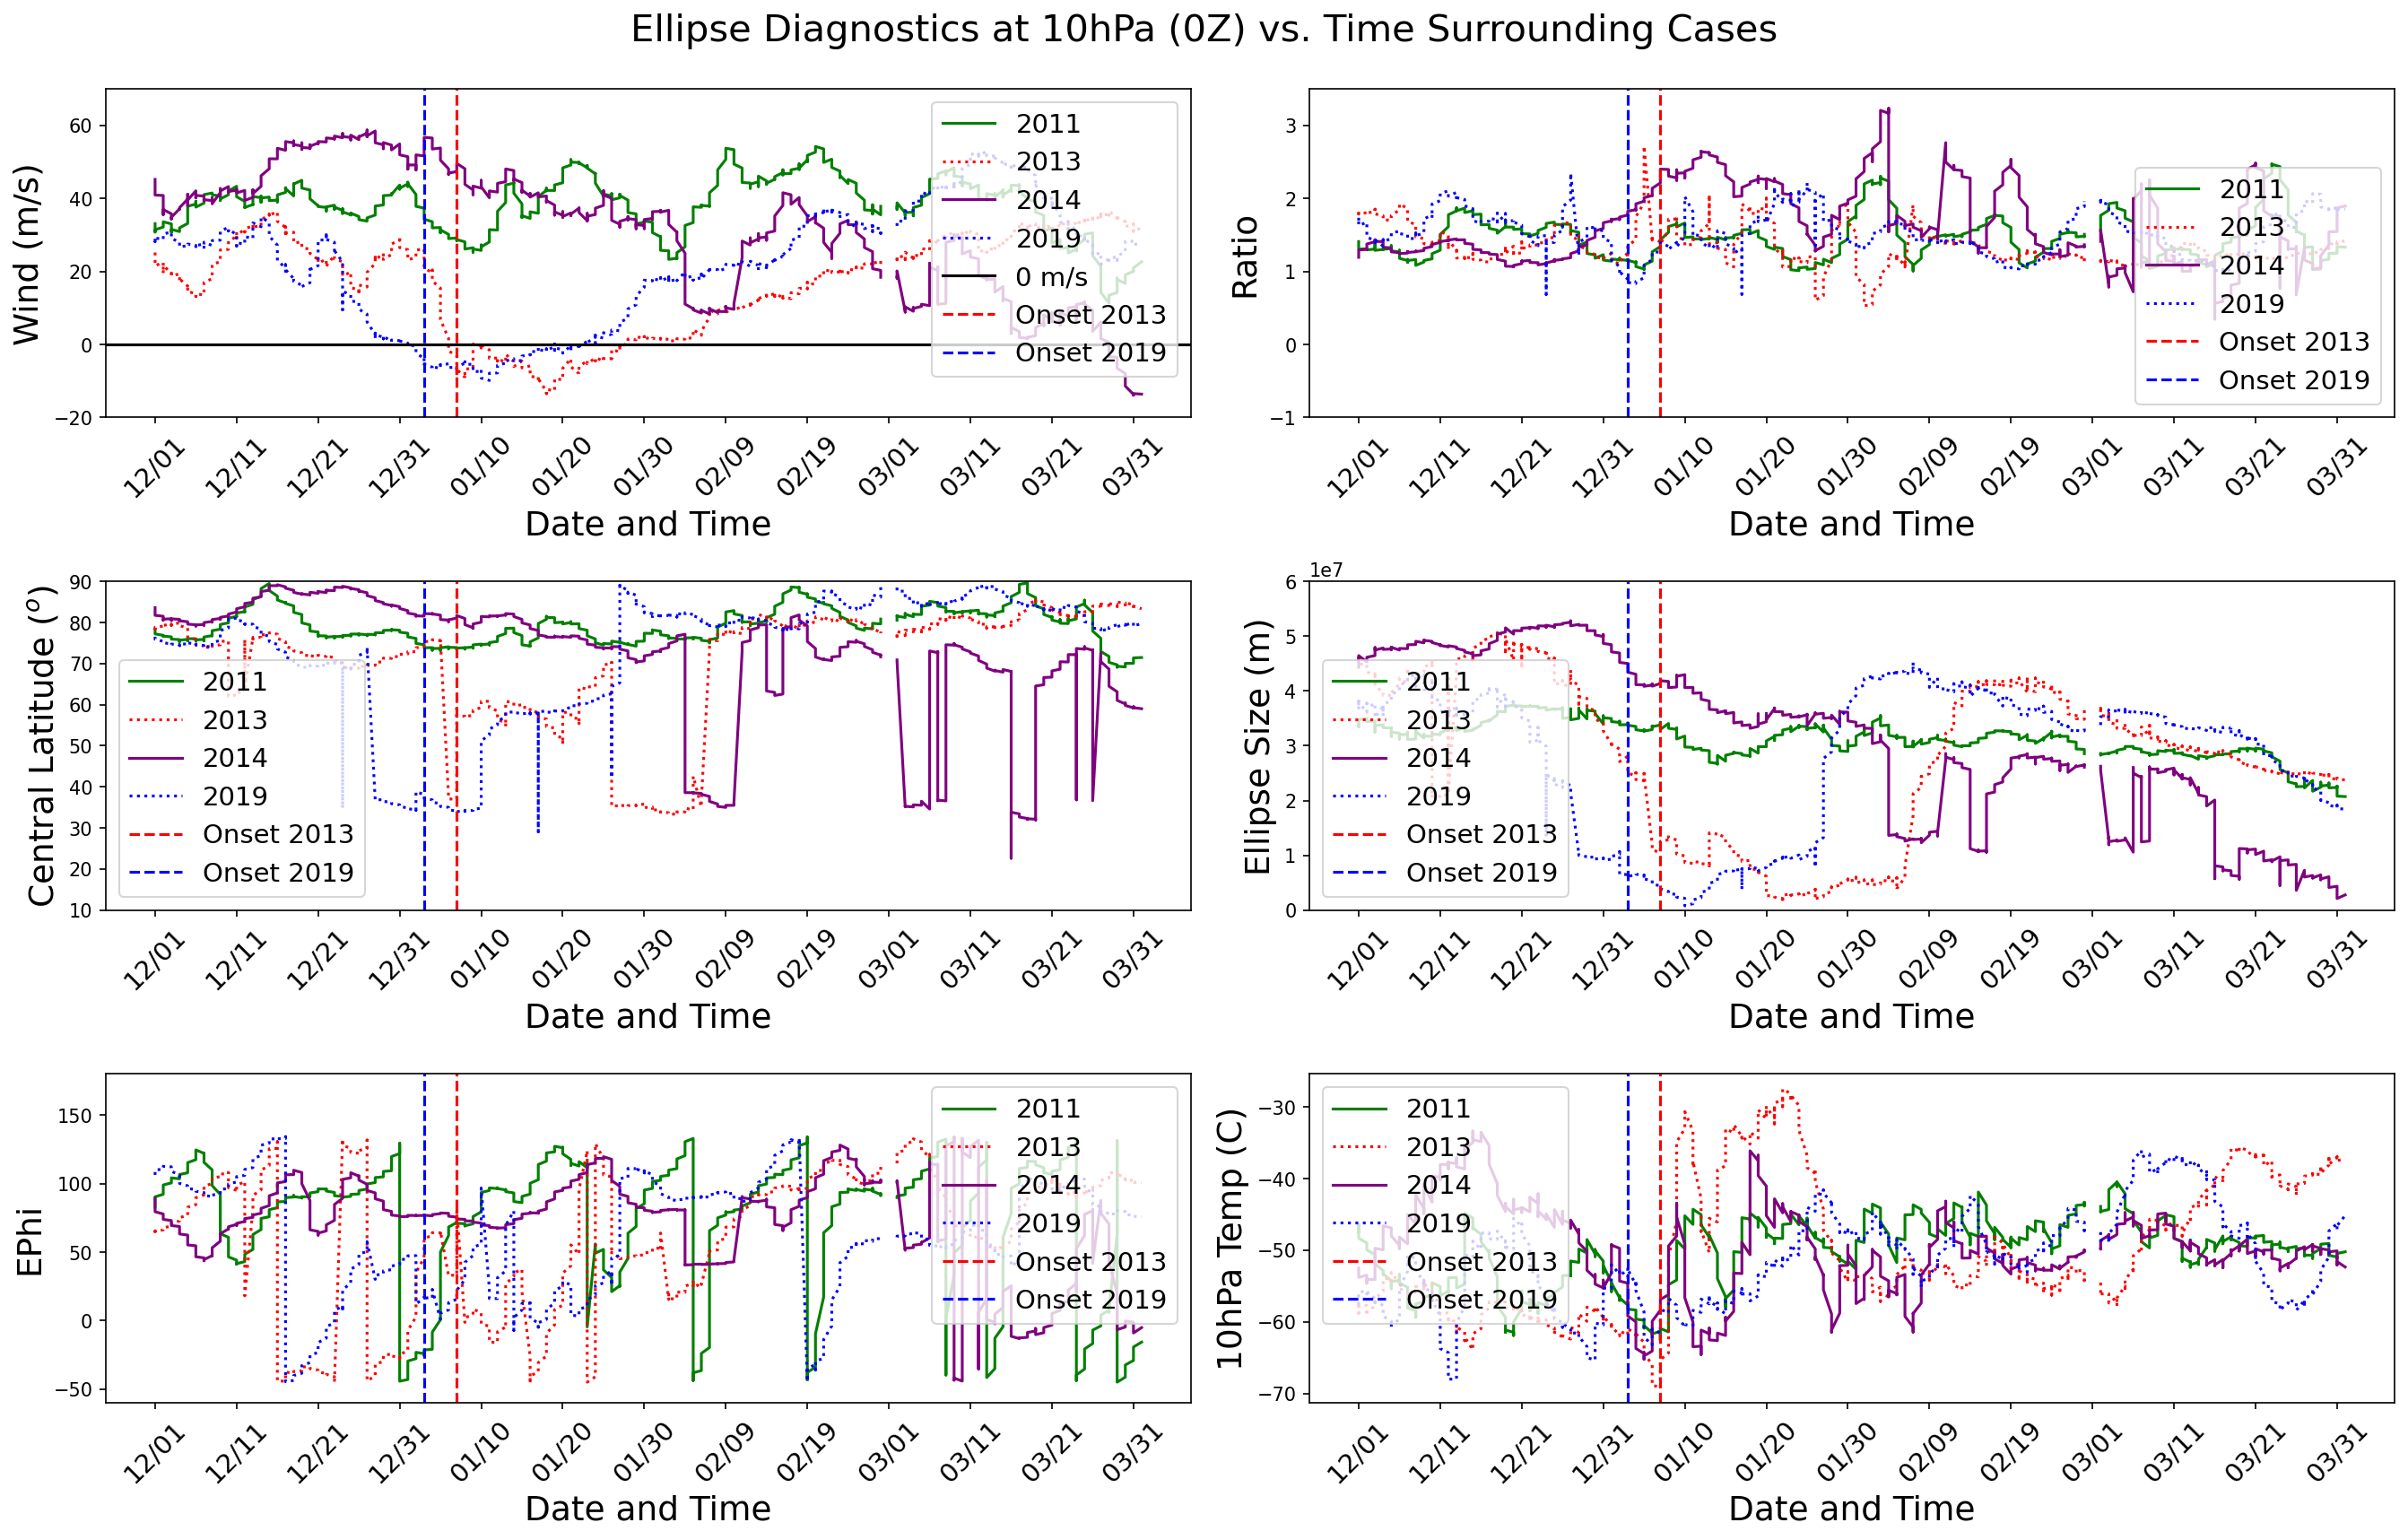

In [18]:

myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()
    
##diagnostics
##2011
w = e10[sswcl[0],int(dates[0][0]):int(dates[0][1])] #wind
rat = ephi_ratio10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
cl = ephi_cenlat10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
sz = ephi_size10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
ep = ephi10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
t = tem10[sswcl[0],int(dates[0][0]):int(dates[0][1])]

##2013
w2 = e10[sswcl[1],int(dates[0][0]):int(dates[0][1])] #wind
rat2 = ephi_ratio10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
cl2 = ephi_cenlat10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
sz2 = ephi_size10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
ep2 = ephi10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
t2 = tem10[sswcl[1],int(dates[0][0]):int(dates[0][1])]

##2014
w3 = e10[sswcl[2],int(dates[2][0]):int(dates[2][1])] #wind
rat3 = ephi_ratio10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
cl3 = ephi_cenlat10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
sz3 = ephi_size10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
ep3 = ephi10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
t3 = tem10[sswcl[2],int(dates[2][0]):int(dates[2][1])]

##2019
w4 = e10[sswcl[3],int(dates[2][0]):int(dates[2][1])] #wind
rat4 = ephi_ratio10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
cl4 = ephi_cenlat10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
sz4 = ephi_size10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
ep4 = ephi10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
t4 = tem10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
    
x = normal_year[int(dates[2][0]):int(dates[2][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.suptitle("Ellipse Diagnostics at 10hPa (0Z) vs. Time Surrounding Cases", fontsize = 20)

ax1 = plt.subplot(3,2,1)
ax1.plot(x, w, linestyle = 'solid', color = 'green', label = "2011")
ax1.plot(x, w2, linestyle = 'dotted', color = 'red', label = "2013")
ax1.plot(x, w3, linestyle = 'solid',  color = 'purple', label = "2014")
ax1.plot(x, w4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax1.axhline(y=0, color='k', linestyle='-', label = "0 m/s")
ax1.set_ylabel("Wind (m/s)", fontsize = 18)
ax1.set_ylim(-20,70)
ax1.set_xlabel("Date and Time", fontsize = 18)
ax1.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax2 = plt.subplot(3,2,2)
ax2.plot(x, rat, linestyle = 'solid', color = 'green', label = "2011")
ax2.plot(x, rat2, linestyle = 'dotted', color = 'red', label = "2013")
ax2.plot(x, rat3, linestyle = 'solid',  color = 'purple', label = "2014")
ax2.plot(x, rat4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax2.set_ylabel("Ratio", fontsize = 18)
ax2.set_ylim(-1,3.5)
ax2.set_xlabel("Date and Time", fontsize = 18)
ax2.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)
    
ax3 = plt.subplot(3,2,3)
ax3.plot(x, cl, linestyle = 'solid', color = 'green', label = "2011")
ax3.plot(x, cl2, linestyle = 'dotted', color = 'red', label = "2013")
ax3.plot(x, cl3, linestyle = 'solid',  color = 'purple', label = "2014")
ax3.plot(x, cl4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax3.set_ylabel("Central Latitude ($^o$)", fontsize = 18)
ax3.set_xlabel("Date and Time", fontsize = 18)
ax3.set_ylim(10,90)
ax3.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax4 = plt.subplot(3,2,4)
ax4.plot(x, sz, linestyle = 'solid', color = 'green', label = "2011")
ax4.plot(x, sz2, linestyle = 'dotted', color = 'red', label = "2013")
ax4.plot(x, sz3, linestyle = 'solid',  color = 'purple', label = "2014")
ax4.plot(x, sz4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax4.set_ylabel("Ellipse Size (m)", fontsize = 18)
ax4.set_ylim(0,60000000)
ax4.set_xlabel("Date and Time", fontsize = 18)
ax4.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax5 = plt.subplot(3,2,5)
ax5.plot(x, ep, linestyle = 'solid', color = 'green', label = "2011")
ax5.plot(x, ep2, linestyle = 'dotted', color = 'red', label = "2013")
ax5.plot(x, ep3, linestyle = 'solid',  color = 'purple', label = "2014")
ax5.plot(x, ep4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax5.set_ylabel("EPhi", fontsize = 18)
ax5.set_ylim(-60,180)
ax5.set_xlabel("Date and Time", fontsize = 18)
ax5.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)

ax6 = plt.subplot(3,2,6)
ax6.plot(x, t, linestyle = 'solid', color = 'green', label = "2011")
ax6.plot(x, t2, linestyle = 'dotted', color = 'red', label = "2013")
ax6.plot(x, t3, linestyle = 'solid',  color = 'purple', label = "2014")
ax6.plot(x, t4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax6.set_ylabel("10hPa Temp (C)", fontsize = 18)
#ax6.set_ylim(-25,20)
ax6.set_xlabel("Date and Time", fontsize = 18)
ax6.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)
    
plt.xticks(rotation=45,fontsize = 14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


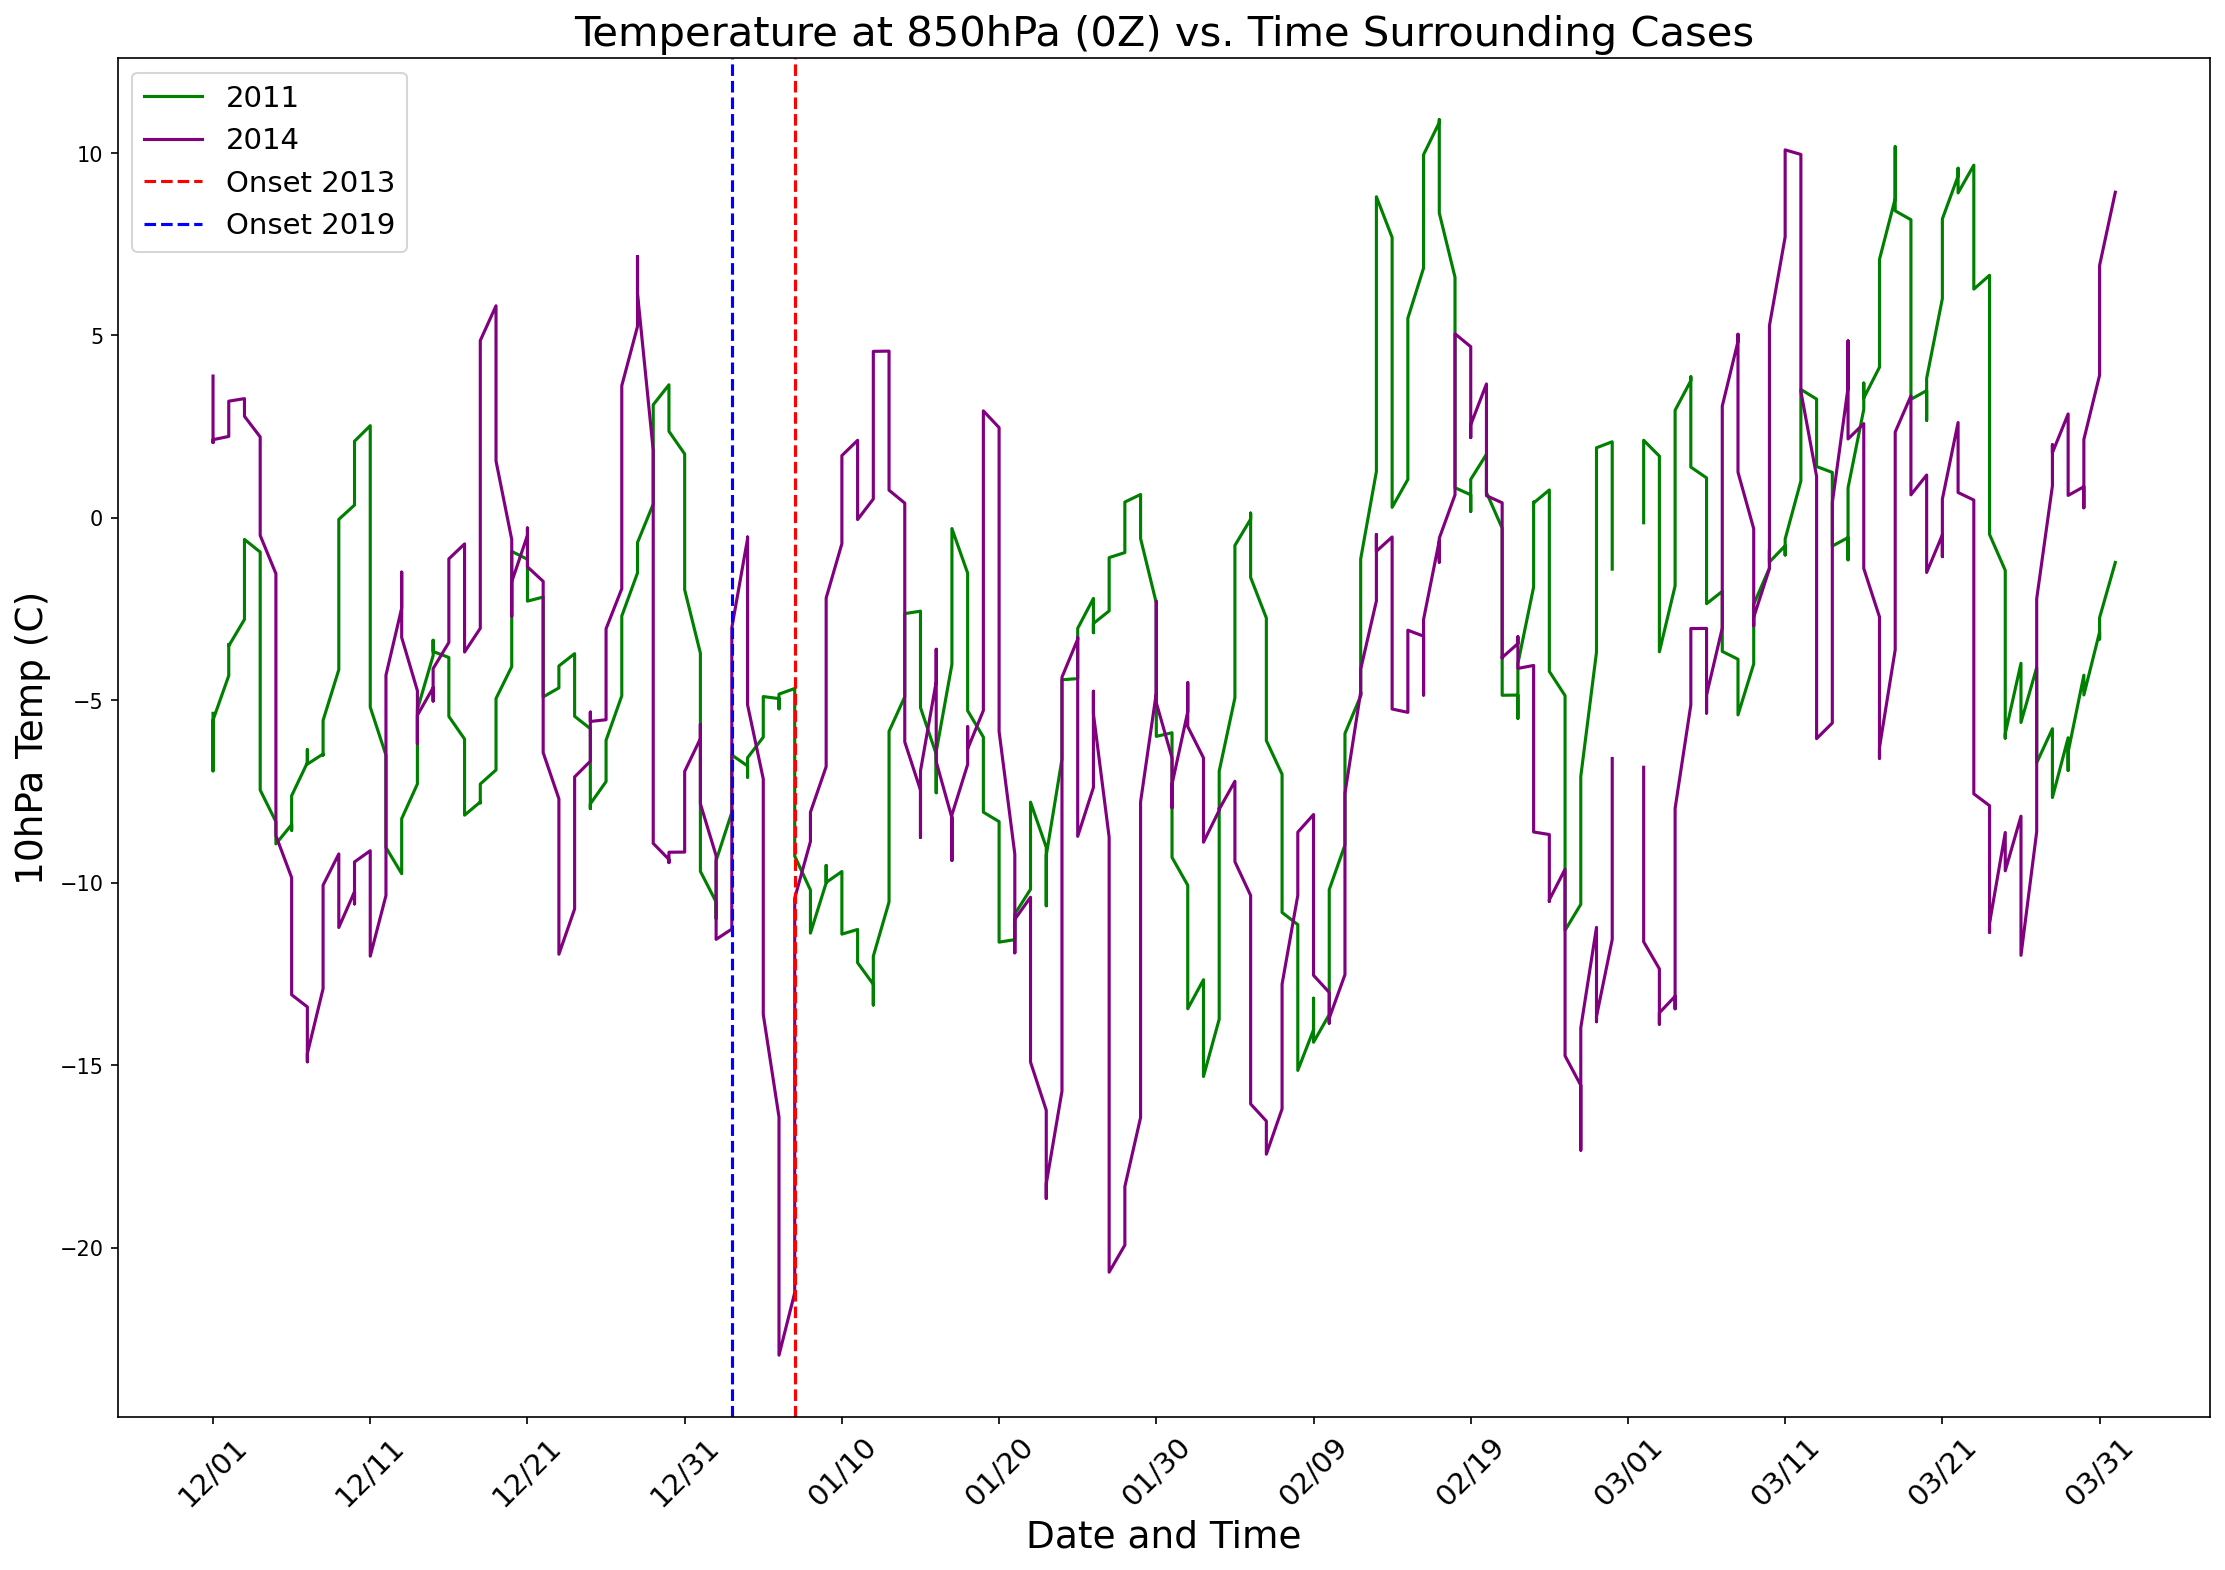

In [19]:
myLocator = mticker.MultipleLocator(10)


normal_year = pd.date_range('2000-12-01','2001-04-01', 
              freq='6H').strftime("%m/%d").tolist()
    
##diagnostics
##2011
w = e10[sswcl[0],int(dates[0][0]):int(dates[0][1])] #wind
rat = ephi_ratio10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
cl = ephi_cenlat10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
sz = ephi_size10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
ep = ephi10[sswcl[0],int(dates[0][0]):int(dates[0][1])]
t = tem[sswcl[0],int(dates[0][0]):int(dates[0][1])]

##2013
w2 = e10[sswcl[1],int(dates[0][0]):int(dates[0][1])] #wind
rat2 = ephi_ratio10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
cl2 = ephi_cenlat10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
sz2 = ephi_size10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
ep2 = ephi10[sswcl[1],int(dates[0][0]):int(dates[0][1])]
t2 = tem[sswcl[1],int(dates[0][0]):int(dates[0][1])]

##2014
w3 = e10[sswcl[2],int(dates[2][0]):int(dates[2][1])] #wind
rat3 = ephi_ratio10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
cl3 = ephi_cenlat10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
sz3 = ephi_size10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
ep3 = ephi10[sswcl[2],int(dates[2][0]):int(dates[2][1])]
t3 = tem[sswcl[2],int(dates[2][0]):int(dates[2][1])]

##2019
w4 = e10[sswcl[3],int(dates[2][0]):int(dates[2][1])] #wind
rat4 = ephi_ratio10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
cl4 = ephi_cenlat10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
sz4 = ephi_size10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
ep4 = ephi10[sswcl[3],int(dates[2][0]):int(dates[2][1])]
t4 = tem[sswcl[3],int(dates[2][0]):int(dates[2][1])]
    
x = normal_year[int(dates[2][0]):int(dates[2][1])]
         
    
fig = plt.figure(figsize=(18,12),dpi=150)
plt.title("Temperature at 850hPa (0Z) vs. Time Surrounding Cases", fontsize = 20)
ax = plt.subplot(1,1,1)
ax.plot(x, t, linestyle = 'solid', color = 'green', label = "2011")
#ax.plot(x, t2, linestyle = 'dotted', color = 'red', label = "2013")
ax.plot(x, t3, linestyle = 'solid',  color = 'purple', label = "2014")
#ax.plot(x, t4, linestyle = 'dotted',  color = 'blue', label = "2019")
ax.set_ylabel("10hPa Temp (C)", fontsize = 18)
#ax6.set_ylim(-25,20)
ax.set_xlabel("Date and Time", fontsize = 18)
ax.xaxis.set_major_locator(myLocator)
plt.xticks(rotation=45,fontsize = 14)
plt.axvline(x=x[148], color='red', linestyle='--',label = "Onset 2013")
plt.axvline(x=x[132], color='blue', linestyle='--',label = "Onset 2019")
plt.legend(fontsize = 14)